In [76]:
from __future__ import annotations
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import unicodedata
from numpy.random import SeedSequence, default_rng
import ray


In [1189]:
allstars = pd.read_table('all_stars_drama_raw.tsv')

In [1190]:
allstars

id      label  isGroup  gender  \
0              motja       Мотя    False  FEMALE   
1            okaemov    Окаемов    False    MALE   
2              masha       Маша    False  FEMALE   
3             leonid     Леонид    False    MALE   
4               nina       Нина    False  FEMALE   
...              ...        ...      ...     ...   
34749  OUTLAWS.1_TGV  Outlaws 1    False    MALE   
34750  OUTLAWS.2_TGV  Outlaws 2    False    MALE   
34751  OUTLAWS.3_TGV  Outlaws 3    False    MALE   
34752       Host_TGV       Host    False    MALE   
34753   Eglamour_TGV   Eglamour    False    MALE   

                                                    text  betweenness  degree  \
0      Кто спрашивает? Его дома нет. И когда будет, н...     0.006313      11   
1      Дайте-ка его сюда. Добрый день. Прочел-с. Хм-х...     0.006313      11   
2      Я к вам.\nЯ не знаю. Я письмо привезла дедушке...     0.006313      11   
3      Извините, пожалуйста, я ошибся квартирой.\nИзв...     0.006313      11   
4      Здравствуйте, Маша.\nСкажите, вы всегда все де...     0.002020      10   
...                                                  ...          ...     ...   
34749  Fellows , stand fast . I see a passenger .\nTh...     0.001852       9   
34750  If there be ten , shrink not , but down with ’...     0.001852       9   
34751  Stand , sir , and throw us that you have about...     0.001852       9   
34752  Now , my young guest , methinks you’re allycho...     0.000000       4   
34753  This is the hour that Madam Sylvia\nEntreated ...     0.000000       1   

       closeness  eigenvector  weightedDegree corpus                 playName  \
0       1.000000     0.299471              36    rus      afinogenov-mashenka   
1       1.000000     0.299471              43    rus      afinogenov-mashenka   
2       1.000000     0.299471              43    rus      afinogenov-mashenka   
3       1.000000     0.299471              36    rus      afinogenov-mashenka   
4       0.916667     0.277517              30    rus      afinogenov-mashenka   
...          ...          ...             ...    ...                      ...   
34749   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34750   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34751   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34752   0.571429     0.127438               4  shake  two-gentlemen-of-verona   
34753   0.470588     0.033083               2  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  
0                1941   Афиногенов  
1                1941   Афиногенов  
2                1941   Афиногенов  
3                1941   Афиногенов  
4                1941   Афиногенов  
...               ...          ...  
34749            1591  Shakespeare  
34750            1591  Shakespeare  
34751            1591  Shakespeare  
34752            1591  Shakespeare  
34753            1591  Shakespeare  

[34754 rows x 14 columns]

In [1191]:
allstars[allstars['text'].apply(lambda x: not isinstance(x, str))]

id                   label  isGroup   gender text  \
11445  le-docteur-sans-pareil  Le Docteur sans Pareil    False  UNKNOWN  NaN   
19288                  frauen                  Frauen     True   FEMALE  NaN   
19331               schnurren               Schnurren     True     MALE  NaN   
19427           hochzeitschor           Hochzeitschor     True  UNKNOWN  NaN   
19461         die_anderen_1-1             Die Anderen     True     MALE  NaN   
...                       ...                     ...      ...      ...  ...   
32610            herr_hunidei            Herr Hunidei    False     MALE  NaN   
33317                  diener                  Diener    False     MALE  NaN   
33319                alle_5-2              Alle (V/2)     True  UNKNOWN  NaN   
33708            Epilogue_2H4                Epilogue    False  UNKNOWN  NaN   
33933   SOLDIERS.YORK.0.1_3H6                 Soldier    False     MALE  NaN   

       betweenness  degree  closeness   eigenvector  weightedDegree corpus  \
11445          0.0      12   1.000000  2.773501e-01              12    fre   
19288          0.0       7   0.539326  4.343191e-02               7    ger   
19331          0.0       1   0.380263  7.480759e-02               1    ger   
19427          0.0      10   0.600000  2.697596e-01              10    ger   
19461          0.0       5   0.420290  4.980374e-02               5    ger   
...            ...     ...        ...           ...             ...    ...   
32610          0.0       7   0.507837  1.072417e-01               7    ger   
33317          0.0       1   0.500000  3.004644e-02               1    ger   
33319          0.0       7   0.615385  1.911791e-01               7    ger   
33708          0.0       0   0.000000  8.691435e-24               0  shake   
33933          0.0       8   0.489796  6.149305e-02               8  shake   

                                    playName  yearNormalized  firstAuthor  
11445           hervilly-docteur-sans-pareil            1887   d'Hervilly  
19288                           alberti-brot            1888      Alberti  
19331            anonym-der-deutsche-student            1779     (Anonym)  
19427  anzengruber-der-pfarrer-von-kirchfeld            1870  Anzengruber  
19461                anzengruber-heimgfunden            1885  Anzengruber  
...                                      ...             ...          ...  
32610       wedekind-die-buechse-der-pandora            1902     Wedekind  
33317                      zschokke-abellino            1795     Zschokke  
33319                      zschokke-abellino            1795     Zschokke  
33708                       henry-iv-part-ii            1598  Shakespeare  
33933                        henry-vi-part-3            1591  Shakespeare  

[73 rows x 14 columns]

In [1192]:
# drop all rows where the text isn't a string

allstars.drop(allstars[allstars['text'].apply(lambda x: not isinstance(x, str))].index, inplace=True)

In [1193]:
allstars

id      label  isGroup  gender  \
0              motja       Мотя    False  FEMALE   
1            okaemov    Окаемов    False    MALE   
2              masha       Маша    False  FEMALE   
3             leonid     Леонид    False    MALE   
4               nina       Нина    False  FEMALE   
...              ...        ...      ...     ...   
34749  OUTLAWS.1_TGV  Outlaws 1    False    MALE   
34750  OUTLAWS.2_TGV  Outlaws 2    False    MALE   
34751  OUTLAWS.3_TGV  Outlaws 3    False    MALE   
34752       Host_TGV       Host    False    MALE   
34753   Eglamour_TGV   Eglamour    False    MALE   

                                                    text  betweenness  degree  \
0      Кто спрашивает? Его дома нет. И когда будет, н...     0.006313      11   
1      Дайте-ка его сюда. Добрый день. Прочел-с. Хм-х...     0.006313      11   
2      Я к вам.\nЯ не знаю. Я письмо привезла дедушке...     0.006313      11   
3      Извините, пожалуйста, я ошибся квартирой.\nИзв...     0.006313      11   
4      Здравствуйте, Маша.\nСкажите, вы всегда все де...     0.002020      10   
...                                                  ...          ...     ...   
34749  Fellows , stand fast . I see a passenger .\nTh...     0.001852       9   
34750  If there be ten , shrink not , but down with ’...     0.001852       9   
34751  Stand , sir , and throw us that you have about...     0.001852       9   
34752  Now , my young guest , methinks you’re allycho...     0.000000       4   
34753  This is the hour that Madam Sylvia\nEntreated ...     0.000000       1   

       closeness  eigenvector  weightedDegree corpus                 playName  \
0       1.000000     0.299471              36    rus      afinogenov-mashenka   
1       1.000000     0.299471              43    rus      afinogenov-mashenka   
2       1.000000     0.299471              43    rus      afinogenov-mashenka   
3       1.000000     0.299471              36    rus      afinogenov-mashenka   
4       0.916667     0.277517              30    rus      afinogenov-mashenka   
...          ...          ...             ...    ...                      ...   
34749   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34750   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34751   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34752   0.571429     0.127438               4  shake  two-gentlemen-of-verona   
34753   0.470588     0.033083               2  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  
0                1941   Афиногенов  
1                1941   Афиногенов  
2                1941   Афиногенов  
3                1941   Афиногенов  
4                1941   Афиногенов  
...               ...          ...  
34749            1591  Shakespeare  
34750            1591  Shakespeare  
34751            1591  Shakespeare  
34752            1591  Shakespeare  
34753            1591  Shakespeare  

[34681 rows x 14 columns]

In [1194]:
def strip_punctuation(text: str) -> str:
    """
    >>> strip_punctuation(u'something')
    u'something'

    >>> strip_punctuation(u'something.,:else really')
    u'somethingelse really'
    """
    punctutation_cats = set(['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po'])
    return ''.join(x for x in text
                   if unicodedata.category(x) not in punctutation_cats)

In [1195]:
def normalise_spaces(text: str) -> str:
    # by default, Python splits on any whitespace eg "a  \t\nb" -> ['a','b']
    return ' '.join(text.split()).strip()

In [1196]:
strip_punctuation(normalise_spaces("Je suis      prêt à \t\tt'écouter, mon\n cher frère,")).lower()

'je suis prêt à técouter mon cher frère'

In [1197]:
cleanText = allstars.text.map(lambda x: normalise_spaces(strip_punctuation(x).lower()))
allstars['cleanText'] = cleanText
allstars

id      label  isGroup  gender  \
0              motja       Мотя    False  FEMALE   
1            okaemov    Окаемов    False    MALE   
2              masha       Маша    False  FEMALE   
3             leonid     Леонид    False    MALE   
4               nina       Нина    False  FEMALE   
...              ...        ...      ...     ...   
34749  OUTLAWS.1_TGV  Outlaws 1    False    MALE   
34750  OUTLAWS.2_TGV  Outlaws 2    False    MALE   
34751  OUTLAWS.3_TGV  Outlaws 3    False    MALE   
34752       Host_TGV       Host    False    MALE   
34753   Eglamour_TGV   Eglamour    False    MALE   

                                                    text  betweenness  degree  \
0      Кто спрашивает? Его дома нет. И когда будет, н...     0.006313      11   
1      Дайте-ка его сюда. Добрый день. Прочел-с. Хм-х...     0.006313      11   
2      Я к вам.\nЯ не знаю. Я письмо привезла дедушке...     0.006313      11   
3      Извините, пожалуйста, я ошибся квартирой.\nИзв...     0.006313      11   
4      Здравствуйте, Маша.\nСкажите, вы всегда все де...     0.002020      10   
...                                                  ...          ...     ...   
34749  Fellows , stand fast . I see a passenger .\nTh...     0.001852       9   
34750  If there be ten , shrink not , but down with ’...     0.001852       9   
34751  Stand , sir , and throw us that you have about...     0.001852       9   
34752  Now , my young guest , methinks you’re allycho...     0.000000       4   
34753  This is the hour that Madam Sylvia\nEntreated ...     0.000000       1   

       closeness  eigenvector  weightedDegree corpus                 playName  \
0       1.000000     0.299471              36    rus      afinogenov-mashenka   
1       1.000000     0.299471              43    rus      afinogenov-mashenka   
2       1.000000     0.299471              43    rus      afinogenov-mashenka   
3       1.000000     0.299471              36    rus      afinogenov-mashenka   
4       0.916667     0.277517              30    rus      afinogenov-mashenka   
...          ...          ...             ...    ...                      ...   
34749   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34750   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34751   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34752   0.571429     0.127438               4  shake  two-gentlemen-of-verona   
34753   0.470588     0.033083               2  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
0                1941   Афиногенов   
1                1941   Афиногенов   
2                1941   Афиногенов   
3                1941   Афиногенов   
4                1941   Афиногенов   
...               ...          ...   
34749            1591  Shakespeare   
34750            1591  Shakespeare   
34751            1591  Shakespeare   
34752            1591  Shakespeare   
34753            1591  Shakespeare   

                                               cleanText  
0      кто спрашивает его дома нет и когда будет неиз...  
1      дайтека его сюда добрый день прочелс хмхм да к...  
2      я к вам я не знаю я письмо привезла дедушке я ...  
3      извините пожалуйста я ошибся квартирой извинит...  
4      здравствуйте маша скажите вы всегда все делает...  
...                                                  ...  
34749  fellows stand fast i see a passenger thats not...  
34750  if there be ten shrink not but down with em pe...  
34751  stand sir and throw us that you have about you...  
34752  now my young guest methinks youre allycholly i...  
34753  this is the hour that madam sylvia entreated m...  

[34681 rows x 15 columns]

In [1199]:
# The supplied id column is useless (full of duplicates) so
# let's just use a numeric id, which we'll need later for
# various things

allstars.id = allstars.index
allstars

id      label  isGroup  gender  \
0          0       Мотя    False  FEMALE   
1          1    Окаемов    False    MALE   
2          2       Маша    False  FEMALE   
3          3     Леонид    False    MALE   
4          4       Нина    False  FEMALE   
...      ...        ...      ...     ...   
34749  34749  Outlaws 1    False    MALE   
34750  34750  Outlaws 2    False    MALE   
34751  34751  Outlaws 3    False    MALE   
34752  34752       Host    False    MALE   
34753  34753   Eglamour    False    MALE   

                                                    text  betweenness  degree  \
0      Кто спрашивает? Его дома нет. И когда будет, н...     0.006313      11   
1      Дайте-ка его сюда. Добрый день. Прочел-с. Хм-х...     0.006313      11   
2      Я к вам.\nЯ не знаю. Я письмо привезла дедушке...     0.006313      11   
3      Извините, пожалуйста, я ошибся квартирой.\nИзв...     0.006313      11   
4      Здравствуйте, Маша.\nСкажите, вы всегда все де...     0.002020      10   
...                                                  ...          ...     ...   
34749  Fellows , stand fast . I see a passenger .\nTh...     0.001852       9   
34750  If there be ten , shrink not , but down with ’...     0.001852       9   
34751  Stand , sir , and throw us that you have about...     0.001852       9   
34752  Now , my young guest , methinks you’re allycho...     0.000000       4   
34753  This is the hour that Madam Sylvia\nEntreated ...     0.000000       1   

       closeness  eigenvector  weightedDegree corpus                 playName  \
0       1.000000     0.299471              36    rus      afinogenov-mashenka   
1       1.000000     0.299471              43    rus      afinogenov-mashenka   
2       1.000000     0.299471              43    rus      afinogenov-mashenka   
3       1.000000     0.299471              36    rus      afinogenov-mashenka   
4       0.916667     0.277517              30    rus      afinogenov-mashenka   
...          ...          ...             ...    ...                      ...   
34749   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34750   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34751   0.695652     0.275380              15  shake  two-gentlemen-of-verona   
34752   0.571429     0.127438               4  shake  two-gentlemen-of-verona   
34753   0.470588     0.033083               2  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
0                1941   Афиногенов   
1                1941   Афиногенов   
2                1941   Афиногенов   
3                1941   Афиногенов   
4                1941   Афиногенов   
...               ...          ...   
34749            1591  Shakespeare   
34750            1591  Shakespeare   
34751            1591  Shakespeare   
34752            1591  Shakespeare   
34753            1591  Shakespeare   

                                               cleanText  
0      кто спрашивает его дома нет и когда будет неиз...  
1      дайтека его сюда добрый день прочелс хмхм да к...  
2      я к вам я не знаю я письмо привезла дедушке я ...  
3      извините пожалуйста я ошибся квартирой извинит...  
4      здравствуйте маша скажите вы всегда все делает...  
...                                                  ...  
34749  fellows stand fast i see a passenger thats not...  
34750  if there be ten shrink not but down with em pe...  
34751  stand sir and throw us that you have about you...  
34752  now my young guest methinks youre allycholly i...  
34753  this is the hour that madam sylvia entreated m...  

[34681 rows x 15 columns]

In [1202]:
allstars.drop(['isGroup', 'text', 'betweenness', 'degree', 'closeness', 'eigenvector', 'weightedDegree'], axis=1, inplace=True)
allstars

id      label  gender corpus                 playName  \
0          0       Мотя  FEMALE    rus      afinogenov-mashenka   
1          1    Окаемов    MALE    rus      afinogenov-mashenka   
2          2       Маша  FEMALE    rus      afinogenov-mashenka   
3          3     Леонид    MALE    rus      afinogenov-mashenka   
4          4       Нина  FEMALE    rus      afinogenov-mashenka   
...      ...        ...     ...    ...                      ...   
34749  34749  Outlaws 1    MALE  shake  two-gentlemen-of-verona   
34750  34750  Outlaws 2    MALE  shake  two-gentlemen-of-verona   
34751  34751  Outlaws 3    MALE  shake  two-gentlemen-of-verona   
34752  34752       Host    MALE  shake  two-gentlemen-of-verona   
34753  34753   Eglamour    MALE  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
0                1941   Афиногенов   
1                1941   Афиногенов   
2                1941   Афиногенов   
3                1941   Афиногенов   
4                1941   Афиногенов   
...               ...          ...   
34749            1591  Shakespeare   
34750            1591  Shakespeare   
34751            1591  Shakespeare   
34752            1591  Shakespeare   
34753            1591  Shakespeare   

                                               cleanText  
0      кто спрашивает его дома нет и когда будет неиз...  
1      дайтека его сюда добрый день прочелс хмхм да к...  
2      я к вам я не знаю я письмо привезла дедушке я ...  
3      извините пожалуйста я ошибся квартирой извинит...  
4      здравствуйте маша скажите вы всегда все делает...  
...                                                  ...  
34749  fellows stand fast i see a passenger thats not...  
34750  if there be ten shrink not but down with em pe...  
34751  stand sir and throw us that you have about you...  
34752  now my young guest methinks youre allycholly i...  
34753  this is the hour that madam sylvia entreated m...  

[34681 rows x 8 columns]

In [1272]:
# Only keep entries where the play name is duplicated
# this drops plays with only one character.

allstars = allstars[allstars.duplicated(['playName'],keep=False)]

In [1273]:
# filter (to keep the ids)

allstars_long = allstars[allstars.cleanText.apply(lambda x: 2000 < len(x.split(' ')))]
allstars_long

id               label  gender corpus                 playName  \
1          1             Окаемов    MALE    rus      afinogenov-mashenka   
12        12  Инна Александровна  FEMALE    rus       andreyev-k-zvezdam   
26        26           Керженцев    MALE    rus            andreyev-mysl   
40        40                Яков    MALE    rus         andreyev-ne-ubiy   
41        41   Василиса Петровна  FEMALE    rus         andreyev-ne-ubiy   
...      ...                 ...     ...    ...                      ...   
34728  34728              Olivia  FEMALE  shake            twelfth-night   
34729  34729            Malvolio    MALE  shake            twelfth-night   
34737  34737           Valentine    MALE  shake  two-gentlemen-of-verona   
34738  34738             Proteus    MALE  shake  two-gentlemen-of-verona   
34740  34740               Julia  FEMALE  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
1                1941   Афиногенов   
12               1906      Андреев   
26               1914      Андреев   
40               1913      Андреев   
41               1913      Андреев   
...               ...          ...   
34728            1601  Shakespeare   
34729            1601  Shakespeare   
34737            1591  Shakespeare   
34738            1591  Shakespeare   
34740            1591  Shakespeare   

                                               cleanText  
1      дайтека его сюда добрый день прочелс хмхм да к...  
12     звонит звонит а все без толку за четыре дня хо...  
26     да так он спит теперь по целым дням это третий...  
40     что задумались василиса петровна я пришел ну д...  
41     да вот думаю все холодно да вот думаю все ты з...  
...                                                  ...  
34728  take the fool away go to youre a dry fool ill ...  
34729  yes and shall do till the pangs of death shake...  
34737  cease to persuade my loving proteus homekeepin...  
34738  wilt thou be gone sweet valentine adieu think ...  
34740  but say lucetta now we are alone wouldst thou ...  

[3301 rows x 8 columns]

In [1206]:
allstars_long[allstars_long.gender.isna()]

id                         label gender corpus  \
33376  33376                     Cleopatra    NaN  shake   
33377  33377                        Antony    NaN  shake   
33383  33383            Enobarbus Domitius    NaN  shake   
33388  33388               Octavius Caesar    NaN  shake   
33480  33480                      Menenius    NaN  shake   
33481  33481            Martius Coriolanus    NaN  shake   
33489  33489                      Aufidius    NaN  shake   
33594  33594                        Hamlet    NaN  shake   
33623  33623                 King Henry IV    NaN  shake   
33625  33625             Sir John Falstaff    NaN  shake   
33626  33626                    Prince Hal    NaN  shake   
33630  33630                       Hotspur    NaN  shake   
33676  33676       Prince Hal King Henry V    NaN  shake   
33688  33688                 King Henry IV    NaN  shake   
33712  33712      Henry V, King of England    NaN  shake   
33779  33779                        Talbot    NaN  shake   
33820  33820                       Suffolk    NaN  shake   
33821  33821                 King Henry VI    NaN  shake   
33822  33822                Queen Margaret    NaN  shake   
33827  33827                          York    NaN  shake   
33868  33868                          Cade    NaN  shake   
33892  33892                       Warwick    NaN  shake   
33894  33894         Edward King Edward IV    NaN  shake   
33896  33896            Richard Gloucester    NaN  shake   
33898  33898                 King Henry VI    NaN  shake   
33903  33903                Queen Margaret    NaN  shake   
33949  33949         King Henry the Eighth    NaN  shake   
33996  33996                   Mark Antony    NaN  shake   
33998  33998                 Marcus Brutus    NaN  shake   
33999  33999                 Caius Cassius    NaN  shake   
34040  34040                          John    NaN  shake   
34044  34044  Bastard Philip Faulconbridge    NaN  shake   
34051  34051                     Constance    NaN  shake   
34071  34071                          Lear    NaN  shake   
34130  34130                       Macbeth    NaN  shake   
34247  34247                      Pericles    NaN  shake   
34299  34299               King Richard II    NaN  shake   
34301  34301    Henry Bolingbroke Hereford    NaN  shake   
34311  34311                  Duke of York    NaN  shake   
34335  34335                       Richard    NaN  shake   
34343  34343               Queen Elizabeth    NaN  shake   
34594  34594                         Timon    NaN  shake   
34686  34686                       Troilus    NaN  shake   
34687  34687                      Pandarus    NaN  shake   
34697  34697                     Thersites    NaN  shake   

                   playName  yearNormalized  firstAuthor  \
33376  antony-and-cleopatra            1606  Shakespeare   
33377  antony-and-cleopatra            1606  Shakespeare   
33383  antony-and-cleopatra            1606  Shakespeare   
33388  antony-and-cleopatra            1606  Shakespeare   
33480            coriolanus            1608  Shakespeare   
33481            coriolanus            1608  Shakespeare   
33489            coriolanus            1608  Shakespeare   
33594                hamlet            1603  Shakespeare   
33623       henry-iv-part-i            1598  Shakespeare   
33625       henry-iv-part-i            1598  Shakespeare   
33626       henry-iv-part-i            1598  Shakespeare   
33630       henry-iv-part-i            1598  Shakespeare   
33676      henry-iv-part-ii            1598  Shakespeare   
33688      henry-iv-part-ii            1598  Shakespeare   
33712               henry-v            1599  Shakespeare   
33779       henry-vi-part-1            1591  Shakespeare   
33820       henry-vi-part-2            1591  Shakespeare   
33821       henry-vi-part-2            1591  Shakespeare   
33822       henry-vi-part-2            1591  Shakespeare   
33827       henry-vi-part-2            1591  Shak

In [1207]:
# first update the women who were wrongly given gender = NaN

women = [
    33376, # Cleopatra
    33833, # Margaret
    33903, # Margaret again
    34051, # Constance
    34343, # Queen Liz
]
allstars_long.loc[allstars_long.id.isin(women), 'gender']= 'FEMALE'
allstars.loc[allstars.id.isin(women), 'gender']= 'FEMALE'

In [1208]:
# Now the rest of those NaNs are male

allstars_long.loc[allstars_long.gender.isna(), 'gender']= 'MALE'
allstars.loc[allstars.gender.isna(), 'gender']= 'MALE'

In [1274]:
allstars.to_pickle('allstars_clean.pkl.zip')

In [1275]:
allstars_long.to_pickle('allstars_long.pkl.zip')

In [1211]:
# run this to skip the cleaning etc above and just read
# in the data

allstars = pd.read_pickle('allstars_clean.pkl.zip')
allstars

id      label  gender corpus                 playName  \
0          0       Мотя  FEMALE    rus      afinogenov-mashenka   
1          1    Окаемов    MALE    rus      afinogenov-mashenka   
2          2       Маша  FEMALE    rus      afinogenov-mashenka   
3          3     Леонид    MALE    rus      afinogenov-mashenka   
4          4       Нина  FEMALE    rus      afinogenov-mashenka   
...      ...        ...     ...    ...                      ...   
34749  34749  Outlaws 1    MALE  shake  two-gentlemen-of-verona   
34750  34750  Outlaws 2    MALE  shake  two-gentlemen-of-verona   
34751  34751  Outlaws 3    MALE  shake  two-gentlemen-of-verona   
34752  34752       Host    MALE  shake  two-gentlemen-of-verona   
34753  34753   Eglamour    MALE  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
0                1941   Афиногенов   
1                1941   Афиногенов   
2                1941   Афиногенов   
3                1941   Афиногенов   
4                1941   Афиногенов   
...               ...          ...   
34749            1591  Shakespeare   
34750            1591  Shakespeare   
34751            1591  Shakespeare   
34752            1591  Shakespeare   
34753            1591  Shakespeare   

                                               cleanText  
0      кто спрашивает его дома нет и когда будет неиз...  
1      дайтека его сюда добрый день прочелс хмхм да к...  
2      я к вам я не знаю я письмо привезла дедушке я ...  
3      извините пожалуйста я ошибся квартирой извинит...  
4      здравствуйте маша скажите вы всегда все делает...  
...                                                  ...  
34749  fellows stand fast i see a passenger thats not...  
34750  if there be ten shrink not but down with em pe...  
34751  stand sir and throw us that you have about you...  
34752  now my young guest methinks youre allycholly i...  
34753  this is the hour that madam sylvia entreated m...  

[34681 rows x 8 columns]

In [1212]:
allstars_long = pd.read_pickle('allstars_long.pkl.zip')
allstars_long

id               label  gender corpus                 playName  \
1          1             Окаемов    MALE    rus      afinogenov-mashenka   
12        12  Инна Александровна  FEMALE    rus       andreyev-k-zvezdam   
26        26           Керженцев    MALE    rus            andreyev-mysl   
40        40                Яков    MALE    rus         andreyev-ne-ubiy   
41        41   Василиса Петровна  FEMALE    rus         andreyev-ne-ubiy   
...      ...                 ...     ...    ...                      ...   
34728  34728              Olivia  FEMALE  shake            twelfth-night   
34729  34729            Malvolio    MALE  shake            twelfth-night   
34737  34737           Valentine    MALE  shake  two-gentlemen-of-verona   
34738  34738             Proteus    MALE  shake  two-gentlemen-of-verona   
34740  34740               Julia  FEMALE  shake  two-gentlemen-of-verona   

       yearNormalized  firstAuthor  \
1                1941   Афиногенов   
12               1906      Андреев   
26               1914      Андреев   
40               1913      Андреев   
41               1913      Андреев   
...               ...          ...   
34728            1601  Shakespeare   
34729            1601  Shakespeare   
34737            1591  Shakespeare   
34738            1591  Shakespeare   
34740            1591  Shakespeare   

                                               cleanText  
1      дайтека его сюда добрый день прочелс хмхм да к...  
12     звонит звонит а все без толку за четыре дня хо...  
26     да так он спит теперь по целым дням это третий...  
40     что задумались василиса петровна я пришел ну д...  
41     да вот думаю все холодно да вот думаю все ты з...  
...                                                  ...  
34728  take the fool away go to youre a dry fool ill ...  
34729  yes and shall do till the pangs of death shake...  
34737  cease to persuade my loving proteus homekeepin...  
34738  wilt thou be gone sweet valentine adieu think ...  
34740  but say lucetta now we are alone wouldst thou ...  

[3303 rows x 8 columns]

In [1213]:
def threegrams(text: str)->list[str]:
    '''3-grams from a single string'''
    
    return [text[i:i+3] for i in range(len(text)-3+1)]

In [5]:
shake_ctr = Counter()
_ = allstars_long[allstars_long.corpus=="shake"].cleanText.map(lambda x: shake_ctr.update(threegrams(x)))
len(shake_ctr)

5921

In [1214]:
shake_ctr.most_common(10)

[(' th', 42422),
 ('the', 24879),
 ('he ', 17327),
 ('nd ', 16951),
 ('and', 15140),
 (' an', 15044),
 ('is ', 12427),
 (' to', 12096),
 ('ll ', 11969),
 (' yo', 11762)]

In [1215]:
# descriptive stats for threegram count distribution

pd.Series(shake_ctr.values()).describe()

count     5921.000000
mean       364.609525
std       1272.688895
min          1.000000
25%          4.000000
50%         31.000000
75%        207.000000
max      42422.000000
dtype: float64

In [1216]:
def threegram_bag(df: pd.Series) -> np.ndarray:
    '''All 3 grams from a Series of strings'''
    
    # need to dropna because some chars still yield 
    # no 3grams (maybe they say 'lo' or something) 
    # and explode turns that into nan
    return df.apply(threegrams).explode().dropna().values

In [1217]:
def unique_threegrams(c: str) -> int:
    return len(set(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText)))

In [1218]:
def total_threegrams(c: str) -> int:
    return len(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText))

In [1219]:
[(c, unique_threegrams(c)) for c in allstars_long.corpus.unique()]

[('rus', 12542), ('fre', 9948), ('ger', 14341), ('shake', 5921)]

In [1220]:
[(c, total_threegrams(c)/1_000_000) for c in allstars_long.corpus.unique()]

[('rus', 4.049405),
 ('fre', 29.832608),
 ('ger', 24.804117),
 ('shake', 2.158853)]

In [13]:
%load_ext rpy2.ipython

In [1276]:
def bootstrap(a, b, count_vectorizer, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, count_vectorizer)
    res.sort()
    # calculate indices for the quantiles and get those values
    # from the sorted results
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs (or a cluster or whatever)
@ray.remote
def char_results(char_id, char_name, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = vocab_sz/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/(len(this_tg)+len(other_tg))*100
    # no need to parallelize these as well
    try:
        vs_other = bootstrap(this_tg, other_tg, cv, rng)
        vs_self = bootstrap(this_tg, this_tg, cv, rng)
    except Exception as e:
        print(f"Died on {char_name} in {pn}")
        print(f"this_tg {len(this_tg)}, other {len(other_tg)}")
        raise e

    # converting a list of dicts is a 'fairly nice' way
    # to build a DataFrame for pandas. This will be one
    # row
    hsh = {
        'id':char_id,
        'Char':char_name,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh


def results_for_corpus(c: str, ss: SeedSequence) -> pd.DataFrame:
    
    df_trim = allstars_long[allstars_long.corpus==c]
    if len(df_trim)==0:
        raise ValueError("No results? Check corpus name.")
        
    results = []

    for pn, play_df in df_trim.groupby('playName'):
        
        # Better hope that there are no dup play names :<
        this_play_speakers = allstars[(allstars.playName==pn)]
        all_threegrams = threegram_bag(this_play_speakers.cleanText)

        # We need a vectorizer that takes a raw sequence of 
        # 3-grams to work with the way we're doing sampling.
        cv = CountVectorizer(analyzer=lambda x: x)

        # Now we can transform any vector of 3-grams and the feature 
        # universes will all be the same. fit on the whole play to 
        # learn the full 3-gram vocab

        # CountVectorizer is threadsafe once fitted (afaik anyway)
        cv.fit([all_threegrams])

        for r in play_df.itertuples(index=False):
            others = allstars[(allstars.playName==r.playName) & (r.id != allstars.id)]
            this_char_threegrams = threegrams(r.cleanText)
            other_chars_threegrams = threegram_bag(others.cleanText)

            # groupby etc is deterministic order, so this should all be reproducible
            # as long as we create these SeedSequences in the same order
            seed = ss.spawn(1)[0]
            rng = default_rng(seed)
            
            # This will return immediately. It gets waited on below (ray.get)
            # to get the actual result.
            results.append(
                char_results.remote(
                    r.id,
                    r.label,
                    pn,
                    this_char_threegrams,
                    other_chars_threegrams,
                    cv,
                    rng
                )
            )

    # wait on all the futures
    energy_df = pd.DataFrame(ray.get(results))
    # merge stuff back in from the original df
    energy_df = energy_df.merge(allstars[['id','gender', 'yearNormalized', 'firstAuthor']],on='id')
    return energy_df


In [1281]:
SS = SeedSequence(2022)

shake = results_for_corpus('shake', SS)

In [1233]:
SS = SeedSequence(2022)

ger = results_for_corpus('ger', SS)

In [1239]:
SS = SeedSequence(2022)

rus = results_for_corpus('rus', SS)

In [ ]:
SS = SeedSequence(2022)

fre = results_for_corpus('fre', SS)

In [1291]:
consolidated = pd.concat([shake,ger,rus,fre]).merge(allstars[['id','corpus']], on='id')

In [1446]:
consolidated.to_pickle('consolidated_dists.pkl.zip')

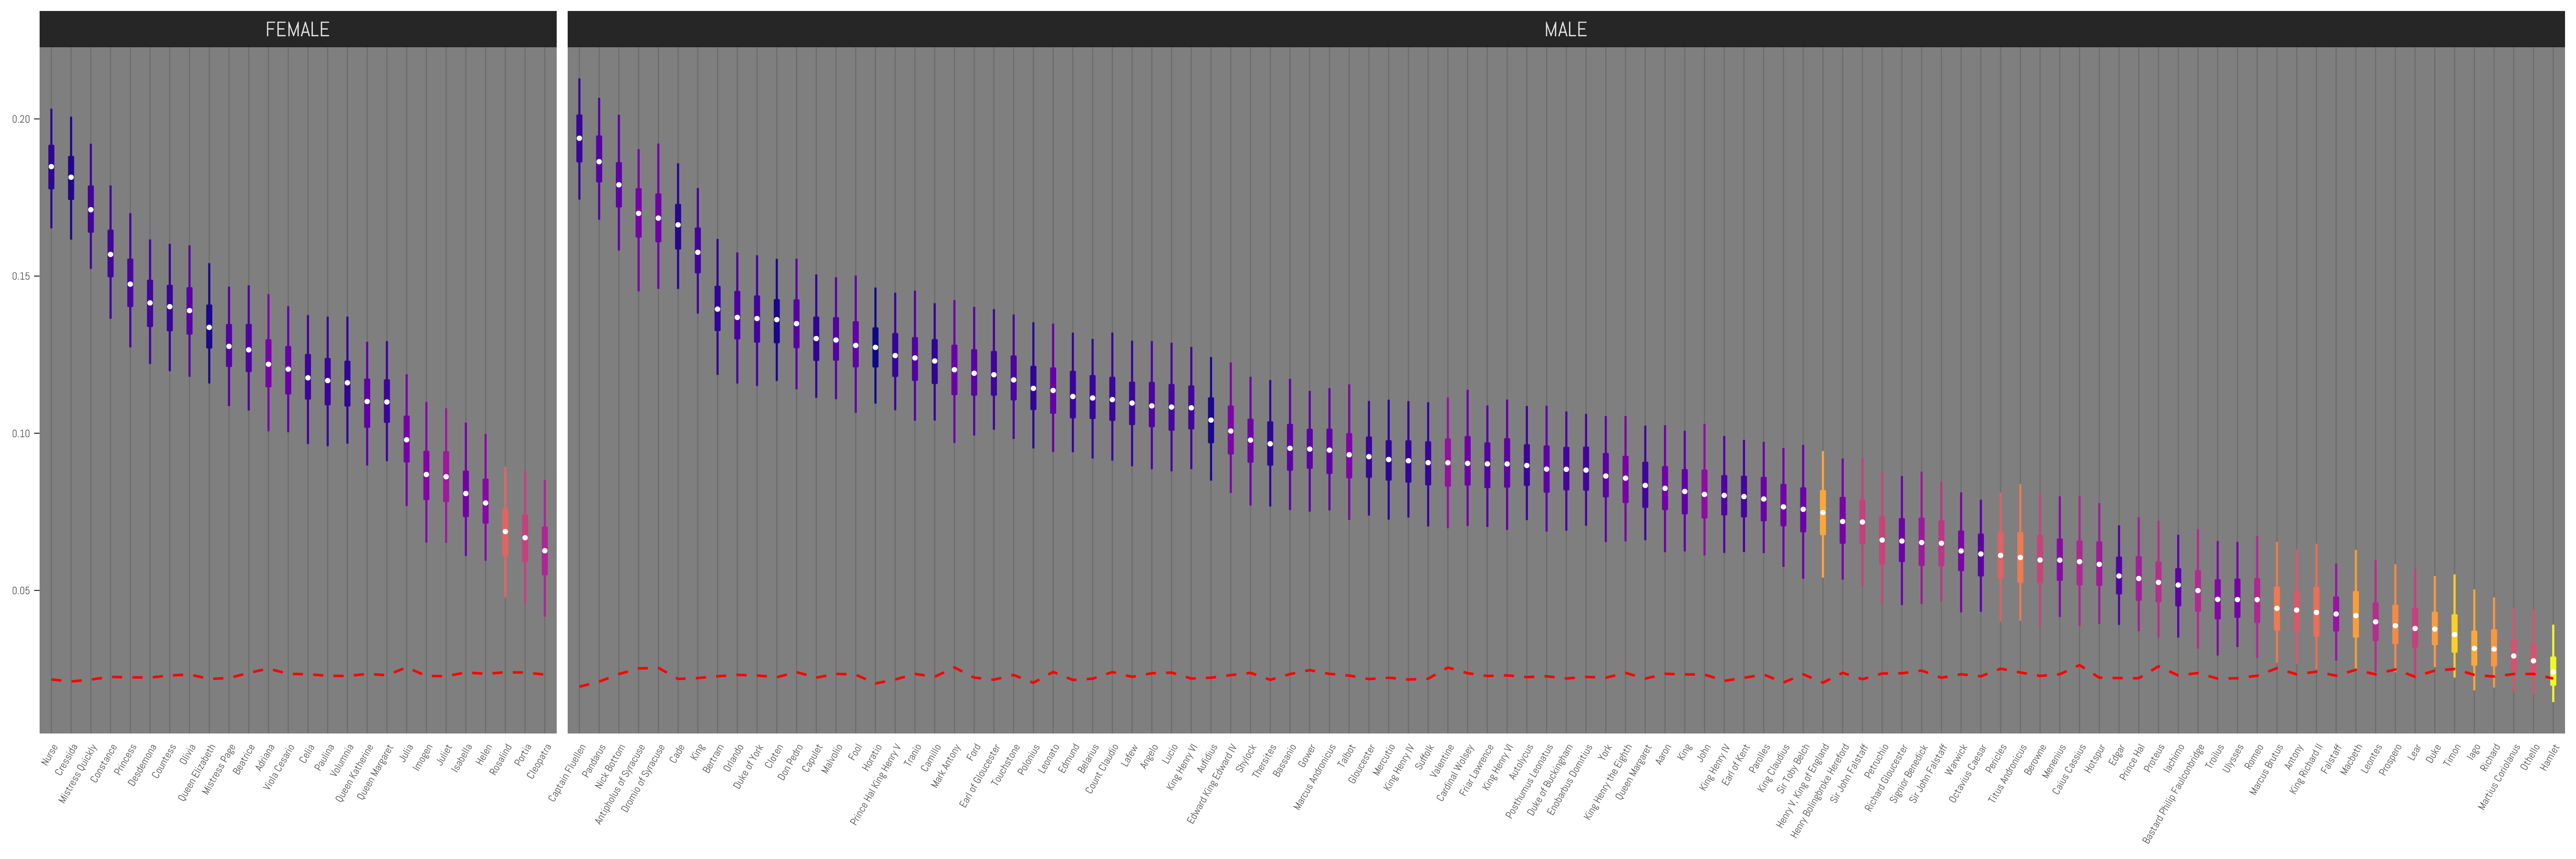

In [1283]:
%%R -i shake -h 6 -w 18 -u in -r 300

library(ggplot2)
library(viridis)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- shake
# this regexp removes everything after and including a literal '.'
# see more below
rem_ids <- function(lab) sub('\\..*', '', lab)

ggplot(df, aes(x=reorder(interaction(Char,id),-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,id)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
# sampling baseline, median of self vs self for this char
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +

scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
# the labels right now are interaction terms with 
# the id like Fred.46546, so remove the trailing
# dot and id with a regexp
scale_x_discrete(labels=rem_ids) +
theme_dark() +
facet_grid(~gender,scales='free_x',space='free_x') +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=21, family="fnt"),
    # facet grid strip
    strip.text.x=element_text(size=33, family="fnt"),

)

In [1228]:
df1 = shake.copy()
df1

id         Char                       Play  VocabSz   PctVocab  \
0    33329  Nick Bottom  a-midsummer-night-s-dream     1661  50.090470   
1    33346     Countess  all-s-well-that-ends-well     1728  50.496786   
2    33347      Bertram  all-s-well-that-ends-well     1717  50.175336   
3    33348        Lafew  all-s-well-that-ends-well     1823  53.272940   
4    33349        Helen  all-s-well-that-ends-well     2105  61.513735   
..     ...          ...                        ...      ...        ...   
122  34728       Olivia              twelfth-night     1785  52.810651   
123  34729     Malvolio              twelfth-night     1765  52.218935   
124  34737    Valentine    two-gentlemen-of-verona     1949  62.870968   
125  34738      Proteus    two-gentlemen-of-verona     2134  68.838710   
126  34740        Julia    two-gentlemen-of-verona     1853  59.774194   

     PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
0    12.331866     0.015935      0.020622      0.023383      0.026634   
1     9.456484     0.015606      0.020043      0.022921      0.026591   
2     8.952816     0.015094      0.019690      0.022681      0.026164   
3     9.727484     0.014832      0.019716      0.022492      0.026203   
4    15.809836     0.015408      0.020017      0.023451      0.026872   
..         ...          ...           ...           ...           ...   
122  11.995773     0.015396      0.020049      0.023258      0.027077   
123  11.615324     0.015532      0.020283      0.023453      0.026739   
124  16.953437     0.017033      0.021783      0.025465      0.029190   
125  20.420915     0.016922      0.021964      0.025855      0.030137   
126  14.394563     0.017142      0.022134      0.025506      0.029712   

     VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
0        0.035117      0.158140       0.172162       0.179046       0.185926   
1        0.033139      0.119732       0.132776       0.140264       0.146885   
2        0.035656      0.118550       0.132838       0.139491       0.146597   
3        0.034911      0.089488       0.102940       0.109597       0.116089   
4        0.034793      0.059413       0.071573       0.077825       0.085222   
..            ...           ...            ...            ...            ...   
122      0.035685      0.117971       0.131716       0.139014       0.146138   
123      0.034821      0.110809       0.123423       0.129653       0.136621   
124      0.038774      0.069749       0.083303       0.090596       0.098028   
125      0.039613      0.034946       0.046581       0.052564       0.058873   
126      0.039148      0.076874       0.091016       0.097914       0.105306   

     VersusOther95  gender  yearNormalized  firstAuthor  
0         0.201329    MALE            1595  Shakespeare  
1         0.160262  FEMALE            1605  Shakespeare  
2         0.161802    MALE            1605  Shakespeare  
3         0.129465    MALE            1605  Shakespeare  
4         0.099803  FEMALE            1605  Shakespeare  
..             ...     ...             ...          ...  
122       0.159792  FEMALE            1601  Shakespeare  
123       0.149644    MALE            1601  Shakespeare  
124       0.111370    MALE            1591  Shakespeare  
125       0.072108    MALE            1591  Shakespeare  
126       0.118771  FEMALE            1591  Shakespeare  

[127 rows x 19 columns]

In [1230]:
# RUN ANALYSIS AGAIN FIRST

df2 = shake.copy()
df2

id         Char                       Play  VocabSz   PctVocab  \
0    33329  Nick Bottom  a-midsummer-night-s-dream     1661  50.090470   
1    33346     Countess  all-s-well-that-ends-well     1728  50.496786   
2    33347      Bertram  all-s-well-that-ends-well     1717  50.175336   
3    33348        Lafew  all-s-well-that-ends-well     1823  53.272940   
4    33349        Helen  all-s-well-that-ends-well     2105  61.513735   
..     ...          ...                        ...      ...        ...   
122  34728       Olivia              twelfth-night     1785  52.810651   
123  34729     Malvolio              twelfth-night     1765  52.218935   
124  34737    Valentine    two-gentlemen-of-verona     1949  62.870968   
125  34738      Proteus    two-gentlemen-of-verona     2134  68.838710   
126  34740        Julia    two-gentlemen-of-verona     1853  59.774194   

     PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
0    12.331866     0.015935      0.020622      0.023383      0.026634   
1     9.456484     0.015606      0.020043      0.022921      0.026591   
2     8.952816     0.015094      0.019690      0.022681      0.026164   
3     9.727484     0.014832      0.019716      0.022492      0.026203   
4    15.809836     0.015408      0.020017      0.023451      0.026872   
..         ...          ...           ...           ...           ...   
122  11.995773     0.015396      0.020049      0.023258      0.027077   
123  11.615324     0.015532      0.020283      0.023453      0.026739   
124  16.953437     0.017033      0.021783      0.025465      0.029190   
125  20.420915     0.016922      0.021964      0.025855      0.030137   
126  14.394563     0.017142      0.022134      0.025506      0.029712   

     VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
0        0.035117      0.158140       0.172162       0.179046       0.185926   
1        0.033139      0.119732       0.132776       0.140264       0.146885   
2        0.035656      0.118550       0.132838       0.139491       0.146597   
3        0.034911      0.089488       0.102940       0.109597       0.116089   
4        0.034793      0.059413       0.071573       0.077825       0.085222   
..            ...           ...            ...            ...            ...   
122      0.035685      0.117971       0.131716       0.139014       0.146138   
123      0.034821      0.110809       0.123423       0.129653       0.136621   
124      0.038774      0.069749       0.083303       0.090596       0.098028   
125      0.039613      0.034946       0.046581       0.052564       0.058873   
126      0.039148      0.076874       0.091016       0.097914       0.105306   

     VersusOther95  gender  yearNormalized  firstAuthor  
0         0.201329    MALE            1595  Shakespeare  
1         0.160262  FEMALE            1605  Shakespeare  
2         0.161802    MALE            1605  Shakespeare  
3         0.129465    MALE            1605  Shakespeare  
4         0.099803  FEMALE            1605  Shakespeare  
..             ...     ...             ...          ...  
122       0.159792  FEMALE            1601  Shakespeare  
123       0.149644    MALE            1601  Shakespeare  
124       0.111370    MALE            1591  Shakespeare  
125       0.072108    MALE            1591  Shakespeare  
126       0.118771  FEMALE            1591  Shakespeare  

[127 rows x 19 columns]

In [1232]:
# OK seems like we have reproducible results

(df1.VersusSelf50 - df2.VersusSelf50).sum()

0.0

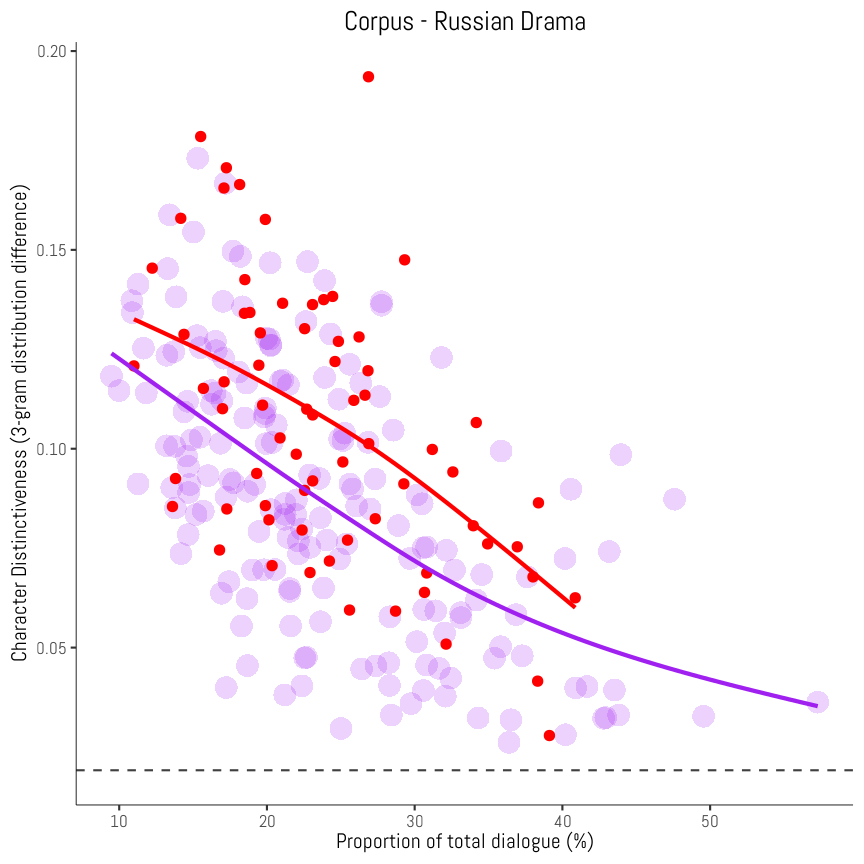

In [1284]:
%%R -i rus -h 6 -w 6 -u in -r 144

# Example for a single plot

library(ggplot2)
library(dplyr)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- rus

baseline <- median(df$VersusSelf50)

ggplot(df, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = df %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = df %>% filter(gender=='FEMALE'), color='red', size=2) +
geom_hline(yintercept=baseline, linetype='dashed', color='grey25') +
geom_smooth(
    data = df %>% filter(gender!='FEMALE'),
    color='purple',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
geom_smooth(
    data = df %>% filter(gender=='FEMALE'),
    color='red',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
# annotate("text", x=12, y=baseline+0.005, label="Baseline: median character distance from self") +

theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Corpus - Russian Drama") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=20),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=16, family="fnt"),
)

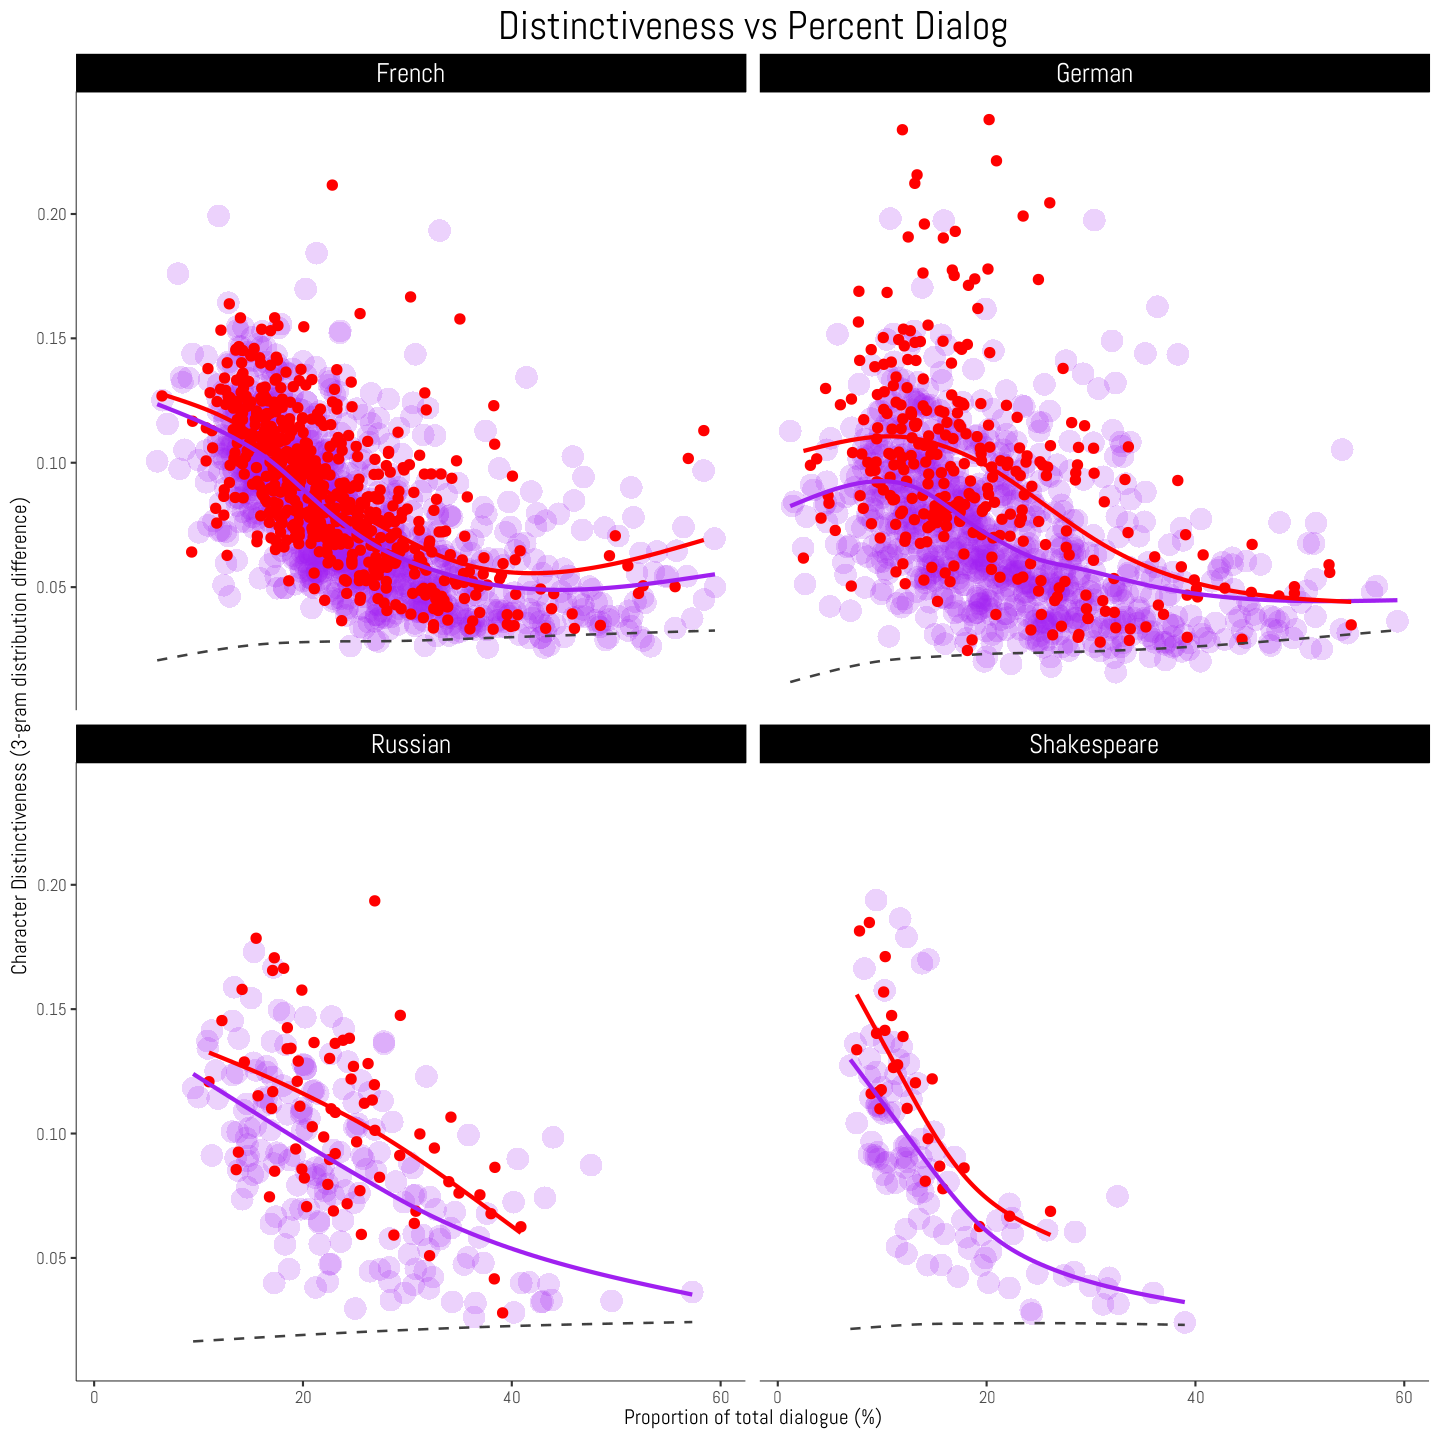

In [1385]:
%%R -i consolidated -h 10 -w 10 -u in -r 144
library(ggplot2)
library(dplyr)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- consolidated %>% filter(PctDialog < 60)

lbl <- as_labeller(c(fre='French', ger='German', rus='Russian', shake='Shakespeare'))

ggplot(df, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = df %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = df %>% filter(gender=='FEMALE'), color='red', size=2) +
geom_smooth(
    aes(y = VersusSelf50,group=1),
    color='grey25',
    size=0.6,
    se=FALSE,
    linetype='dashed',
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
geom_smooth(
    data = df %>% filter(gender!='FEMALE'),
    color='purple',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
geom_smooth(
    data = df %>% filter(gender=='FEMALE'),
    color='red',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
# annotate("text", x=12, y=baseline+0.005, label="Baseline: median character distance from self") +
facet_wrap(~corpus, labeller=lbl, nrow = 2) +
    
theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Distinctiveness vs Percent Dialog") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=30),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=16, family="fnt"),
    strip.text.x=element_text(size=20, family="fnt",color='white'),
    strip.background=element_rect(color='black',fill='black'),
    panel.spacing = unit(0.5, "lines"),
)

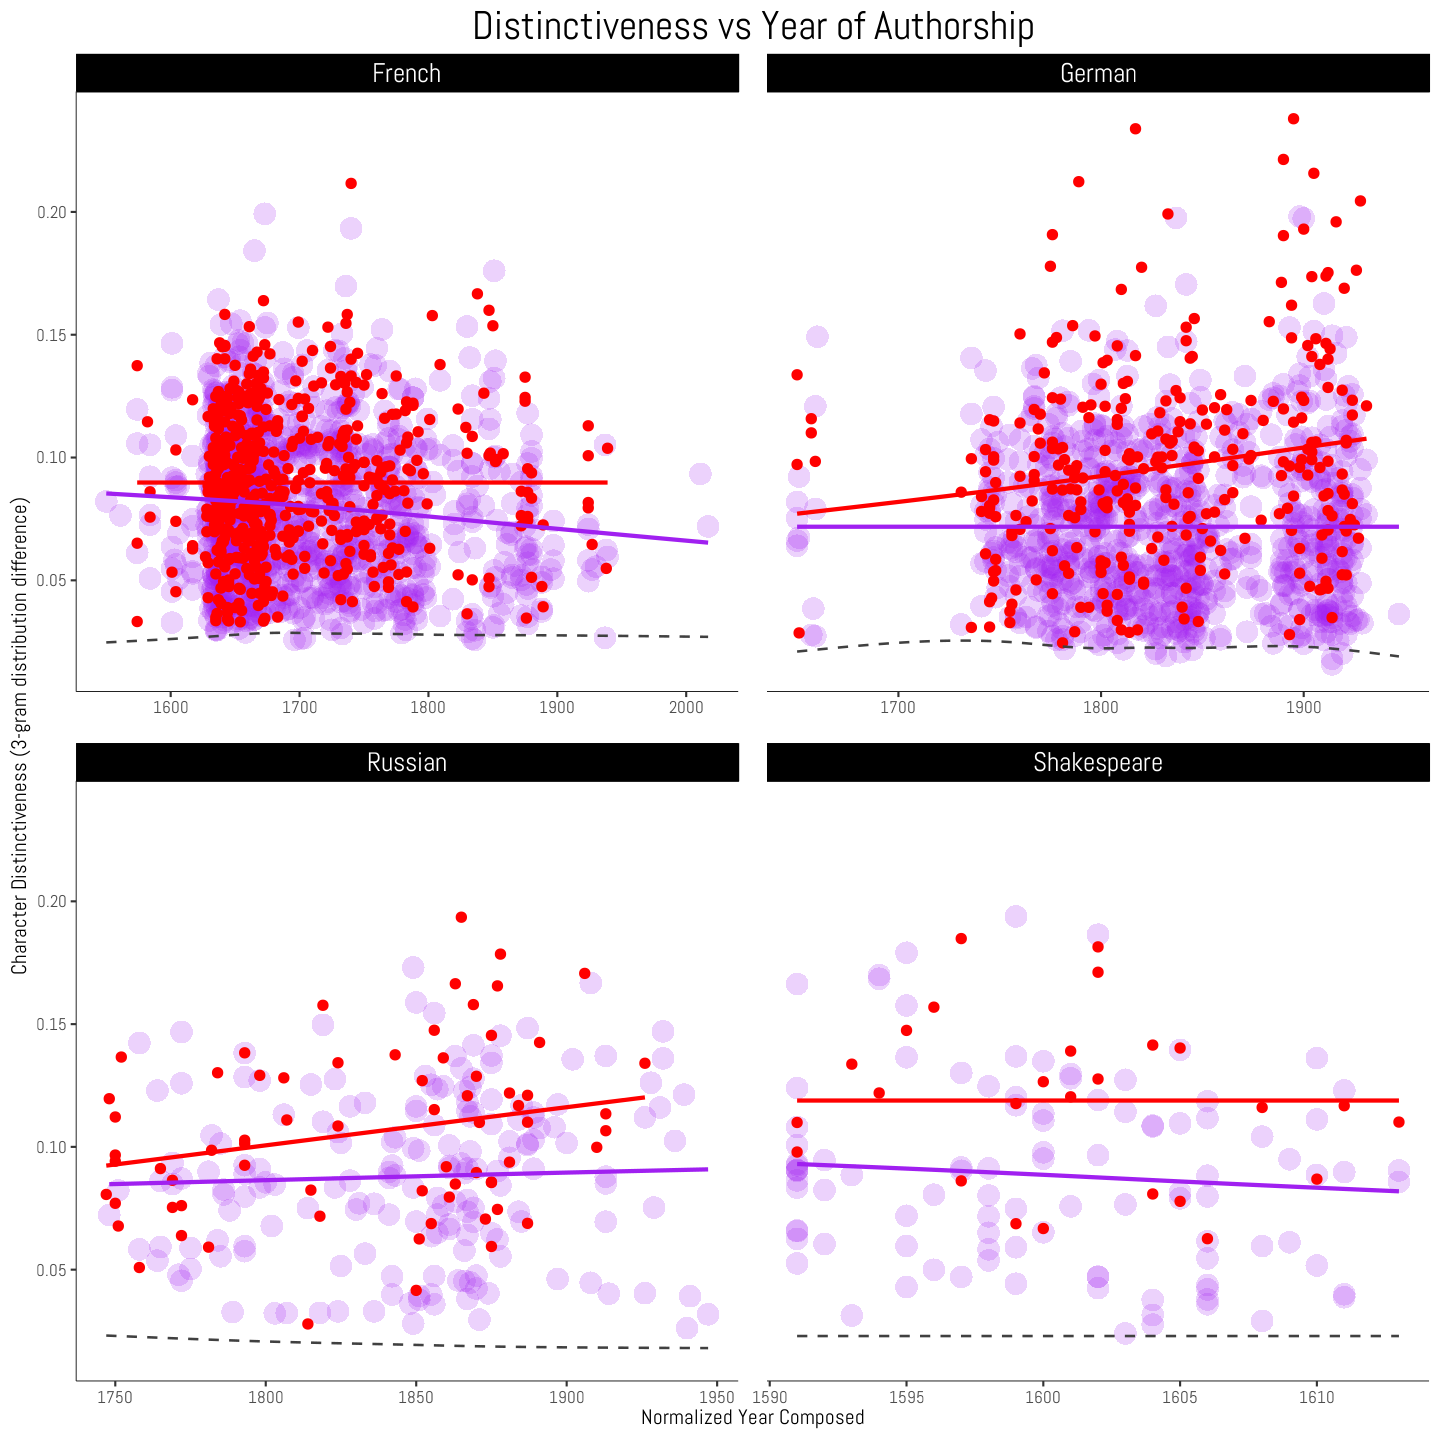

In [ ]:
%%R -i consolidated -h 10 -w 10 -u in -r 144
library(ggplot2)
library(dplyr)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- consolidated %>% filter(PctDialog < 60) %>% filter(yearNormalized > 1500)

baseline <- median(df$VersusSelf50)
lbl <- as_labeller(c(fre='French', ger='German', rus='Russian', shake='Shakespeare'))

ggplot(df, aes(y=VersusOther50, x = yearNormalized)) +
geom_point(data = df %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = df %>% filter(gender=='FEMALE'), color='red', size=2) +
geom_smooth(
    aes(y = VersusSelf50,group=1),
    color='grey25',
    size=0.6,
    se=FALSE,
    linetype='dashed',
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
geom_smooth(
    data = df %>% filter(gender!='FEMALE'),
    color='purple',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
geom_smooth(
    data = df %>% filter(gender=='FEMALE'),
    color='red',
    se=FALSE,
    method='gam',
    formula=y ~ s(x, bs = "cs")
) +
# annotate("text", x=12, y=baseline+0.005, label="Baseline: median character distance from self") +
facet_wrap(~corpus, labeller=lbl, scales = 'free_x', nrow = 2) +
    
theme_bw() +
xlab("Normalized Year Composed") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Distinctiveness vs Year of Authorship") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=30),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=16, family="fnt"),
    strip.text.x=element_text(size=20, family="fnt",color='white'),
    strip.background=element_rect(color='black',fill='black'),
    panel.spacing = unit(1, "lines"),
)

In [1289]:
consolidated

id           Char                       Play  VocabSz   PctVocab  \
0     33329    Nick Bottom  a-midsummer-night-s-dream     1661  50.090470   
1     33346       Countess  all-s-well-that-ends-well     1728  50.496786   
2     33347        Bertram  all-s-well-that-ends-well     1717  50.175336   
3     33348          Lafew  all-s-well-that-ends-well     1823  53.272940   
4     33349          Helen  all-s-well-that-ends-well     2105  61.513735   
...     ...            ...                        ...      ...        ...   
1739  19229      Madeleine             zola-madeleine     1674  71.112999   
1740  19235        Laurent        zola-therese-raquin     1955  63.268608   
1741  19236        Therese        zola-therese-raquin     2052  66.407767   
1742  19237  Madame Raquin        zola-therese-raquin     1735  56.148867   
1743  19240        Suzanne        zola-therese-raquin     1730  55.987055   

      PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
0     12.331866     0.015935      0.020622      0.023383      0.026634   
1      9.456484     0.015606      0.020043      0.022921      0.026591   
2      8.952816     0.015094      0.019690      0.022681      0.026164   
3      9.727484     0.014832      0.019716      0.022492      0.026203   
4     15.809836     0.015408      0.020017      0.023451      0.026872   
...         ...          ...           ...           ...           ...   
1739  38.274443     0.021877      0.028332      0.032530      0.037431   
1740  17.936107     0.016565      0.022139      0.025193      0.028801   
1741  21.084844     0.017173      0.022328      0.025785      0.029682   
1742  14.797206     0.016704      0.021379      0.024850      0.028975   
1743  15.027815     0.016828      0.021613      0.024993      0.028655   

      VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
0         0.035117      0.158140       0.172162       0.179046       0.185926   
1         0.033139      0.119732       0.132776       0.140264       0.146885   
2         0.035656      0.118550       0.132838       0.139491       0.146597   
3         0.034911      0.089488       0.102940       0.109597       0.116089   
4         0.034793      0.059413       0.071573       0.077825       0.085222   
...            ...           ...            ...            ...            ...   
1739      0.048518      0.095153       0.113839       0.122928       0.131861   
1740      0.037277      0.050635       0.064803       0.071836       0.079548   
1741      0.038792      0.042909       0.056136       0.063189       0.070247   
1742      0.037680      0.110823       0.125611       0.132719       0.141234   
1743      0.038028      0.103051       0.116507       0.124474       0.131573   

      VersusOther95   gender  yearNormalized  firstAuthor  
0          0.201329     MALE            1595  Shakespeare  
1          0.160262   FEMALE            1605  Shakespeare  
2          0.161802     MALE            1605  Shakespeare  
3          0.129465     MALE            1605  Shakespeare  
4          0.099803   FEMALE            1605  Shakespeare  
...             ...      ...             ...          ...  
1739       0.150471   FEMALE            1875         Zola  
1740       0.093777     MALE            1875         Zola  
1741       0.086257  UNKNOWN            1875         Zola  
1742       0.154184   FEMALE            1875         Zola  
1743       0.146811   FEMALE            1875         Zola  

[3301 rows x 19 columns]

# Most Distinctive Authors, Overall

Median here is the median of medians (using VsOther50 as the summary 'distinctiveness' stat)

In [1397]:
consolidated.groupby('firstAuthor').VersusOther50.agg(['count','min','max','median']).query('count > 10').sort_values(by='median', ascending=False).head(20)

count       min       max    median
firstAuthor                                           
Anzengruber           17  0.024337  0.133185  0.106203
Piron                 11  0.028125  0.721072  0.104518
Genlis                13  0.050836  0.159946  0.100777
Birch-Pfeiffer        14  0.044830  0.124549  0.098474
La Tessonerie         12  0.038083  0.154441  0.095438
Rotrou                54  0.036753  0.146375  0.094145
Островский            63  0.029653  0.193531  0.093790
Mareschal             28  0.030009  0.139648  0.093552
Molière               50  0.028756  0.199233  0.093133
Musset                21  0.026301  0.153647  0.092270
Weißenthurn           17  0.031147  0.233864  0.091984
Voltaire              72  0.030535  0.144494  0.091857
Scarron               23  0.032886  0.155715  0.091762
Boyer                 46  0.042647  0.146637  0.090865
Shakespeare          127  0.024053  0.193851  0.090596
Magnon                18  0.034181  0.114194  0.089224
Puget de la Serre     14  0.038484  0.158269  0.089173
Kleist                21  0.033636  0.168446  0.088976
Raimund               13  0.032567  0.161776  0.088650
Boissy                17  0.041130  0.154651  0.088461

# Most Distinctive Authors by Corpus

In [1429]:
consolidated.groupby(['corpus','firstAuthor']).VersusOther50.agg(['count','min','max','median']).query('count > 10').groupby('corpus')['median'].nlargest(10)

corpus  corpus  firstAuthor   
fre     fre     Piron             0.104518
                Genlis            0.100777
                La Tessonerie     0.095438
                Rotrou            0.094145
                Mareschal         0.093552
                Molière           0.093133
                Musset            0.092270
                Voltaire          0.091857
                Scarron           0.091762
                Boyer             0.090865
ger     ger     Anzengruber       0.106203
                Birch-Pfeiffer    0.098474
                Weißenthurn       0.091984
                Kleist            0.088976
                Raimund           0.088650
                Hauptmann         0.087054
                Krüger            0.085993
                Gottsched         0.085888
                Iffland           0.084583
                Klinger           0.081750
rus     rus     Островский        0.093790
                Княжнин           0.086777
                Тургене

In [1430]:
consolidated.firstAuthor.nunique()

451

R[write to console]: Picking joint bandwidth of 76.7



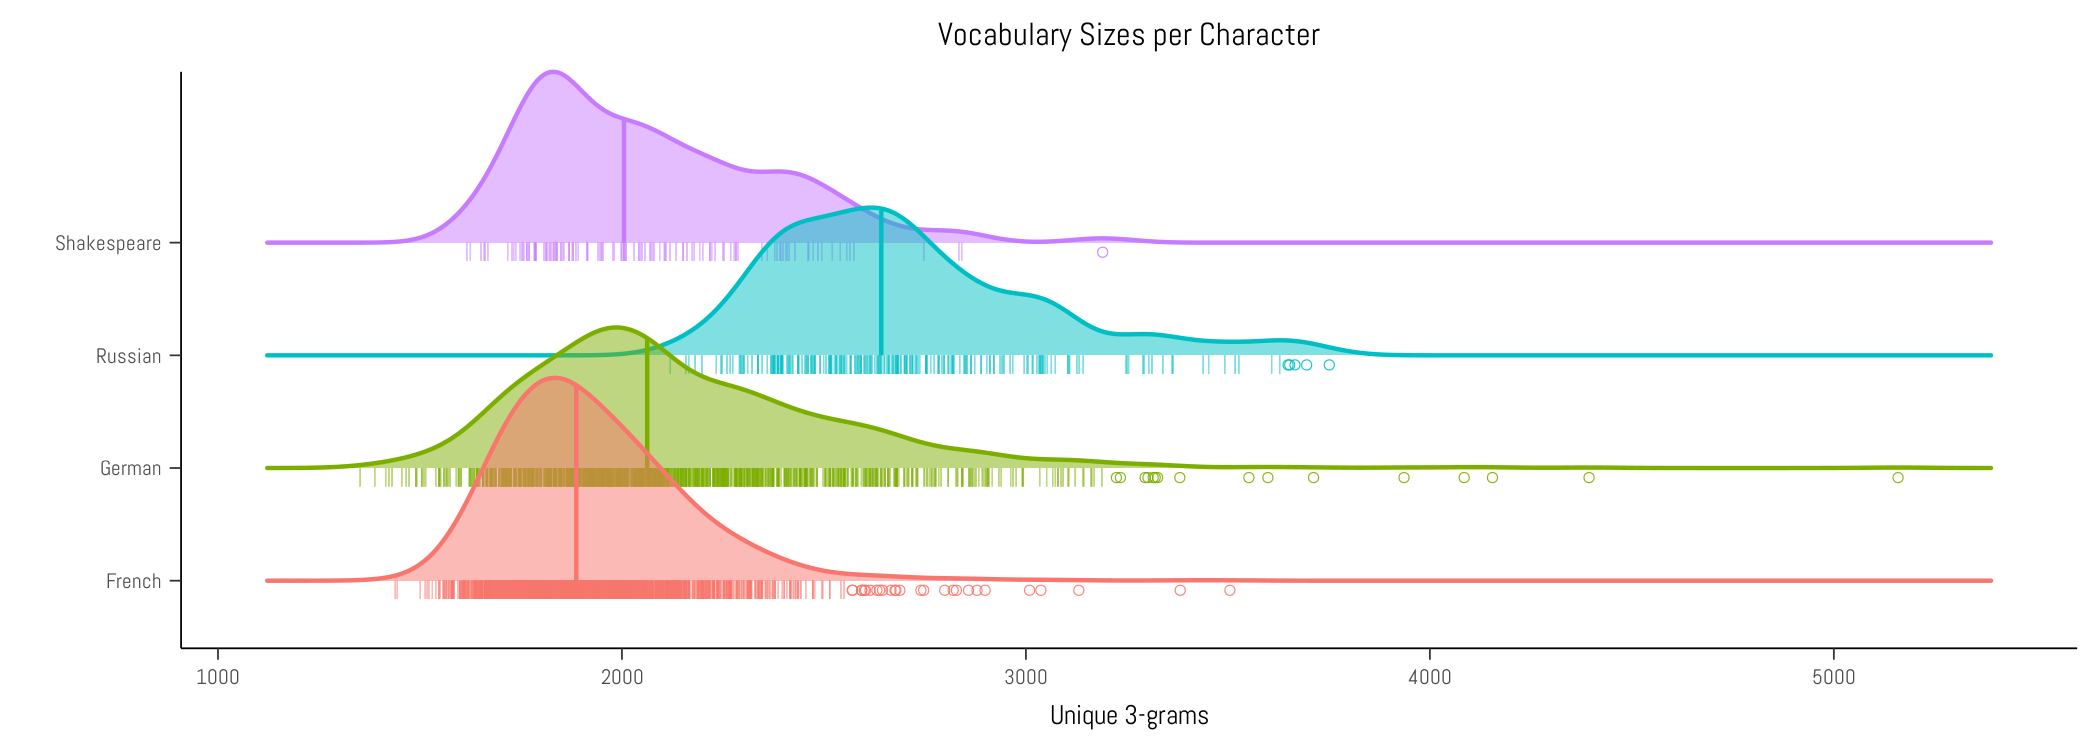

In [1444]:
%%R -i consolidated -h 2.5 -w 7 -u in -r 300

library(ggridges)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- consolidated

# 'standard' IQR scale for outliers is 1.5, but that is
# really meant for gaussian dists, which this definitely isn't.
# However this is, essentially, a magic number to make the
# outlier threshhold look 'right' (to me)
iqr_scale <- 2.5

# this is a very small df (4 rows)
boundaries <- df %>% 
    group_by(corpus) %>% 
    summarize(
        # for each corpus, get the edges of the outlier band
        # which is IQR*iqr_scale above 3Q and below 1Q
        'Hi' = (IQR(VocabSz)*iqr_scale) + quantile(VocabSz)[3],
        'Lo' = quantile(VocabSz)[1] - (IQR(VocabSz)*iqr_scale)
    )
# don't know a better way to do this? merge those boundaries in
# to the whole main df so every row has a Hi and Lo entry, then filter
# for rows where the VocabSz is outside the bounds
outliers <- tibble(merge(df, boundaries, by = 'corpus')) %>%
    filter(VocabSz > Hi | VocabSz < Lo)
inliers <- tibble(merge(df, boundaries, by = 'corpus')) %>%
    filter(VocabSz < Hi & VocabSz > Lo)
    
ggplot(df, aes(VocabSz, corpus, fill = corpus, color=corpus)) +
coord_cartesian(clip = "off") +
geom_point(data=inliers, shape='|', size=5, position = position_nudge(y = -0.085), alpha=0.5) +
geom_point(data=outliers, shape=1, size=1, stroke=0.2, position = position_nudge(y = -0.085),alpha=0.9) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.5
) +
    
scale_y_discrete(labels=c("French", "German", "Russian", "Shakespeare")) +
theme_bw() +
xlab("Unique 3-grams") +
ylab("") +
ggtitle("Vocabulary Sizes per Character") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=24),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=20, family="fnt"),
)

R[write to console]: Picking joint bandwidth of 0.00703

R[write to console]: Picking joint bandwidth of 0.00863

R[write to console]: Picking joint bandwidth of 0.012

R[write to console]: Picking joint bandwidth of 0.0149



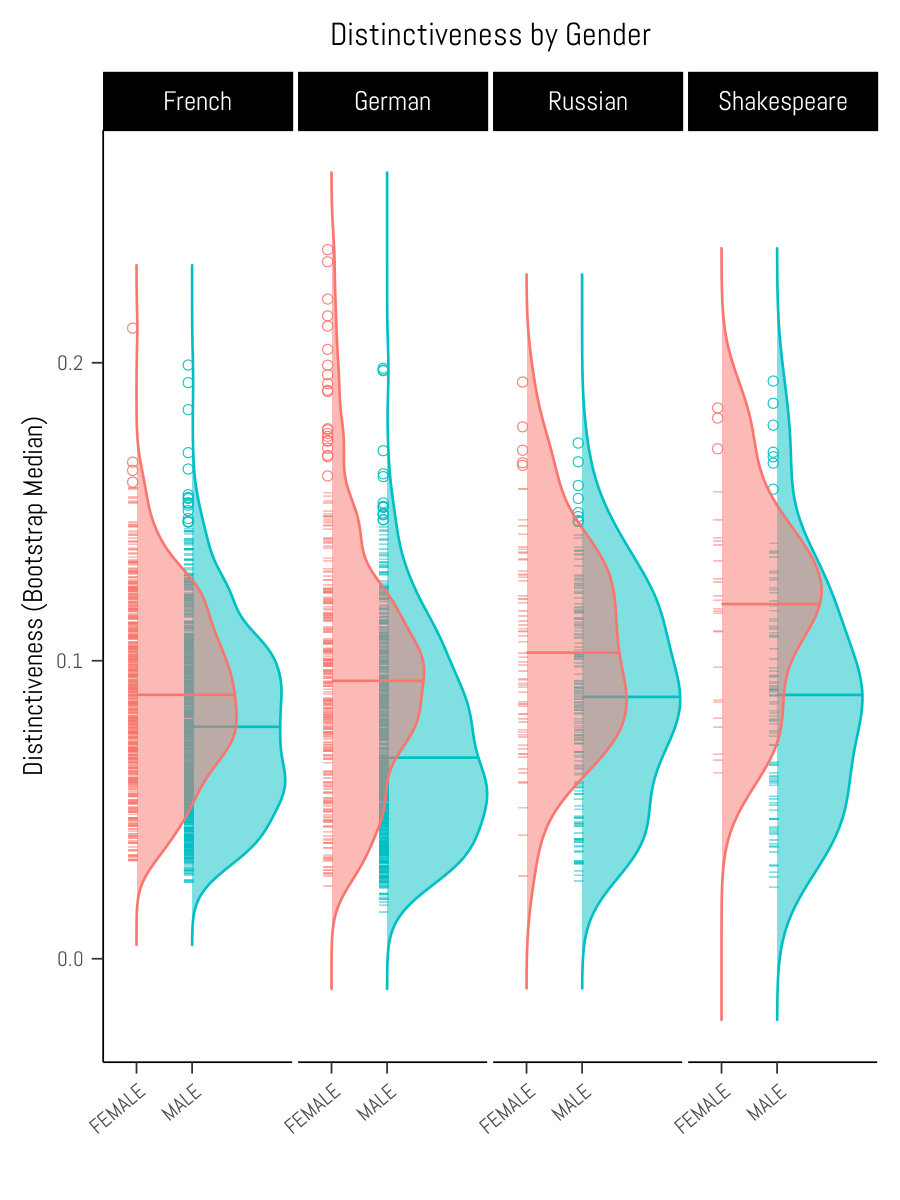

In [1447]:
%%R -i consolidated -h 4 -w 3 -u in -r 300

df <- consolidated %>% 
    filter(PctDialog < 60) %>%
    filter(gender != 'UNKNOWN')

library(ggridges)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

# 'standard' IQR scale for outliers is 1.5, but that is
# really meant for gaussian dists, which this definitely isn't.
# However this is, essentially, a magic number to make the
# outlier threshhold look 'right' (to me)
iqr_scale <- 1.5

# this is a very small df (4 rows)
boundaries <- df %>% 
    group_by(gender) %>% 
    summarize(
        # for each corpus, get the edges of the outlier band
        # which is IQR*iqr_scale above 3Q and below 1Q
        'Hi' = (IQR(VersusOther50)*iqr_scale) + quantile(VersusOther50)[3],
        'Lo' = quantile(VersusOther50)[1] - (IQR(VersusOther50)*iqr_scale)
    )
# don't know a better way to do this? merge those boundaries in
# to the whole main df so every row has a Hi and Lo entry, then filter
# for rows where the VocabSz is outside the bounds
outliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(VersusOther50 > Hi | VersusOther50 < Lo)
inliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(VersusOther50 < Hi & VersusOther50 > Lo)

ggplot(df, aes(VersusOther50, gender, fill = gender, color=gender)) +
geom_point(data=inliers, shape='–', size=6, position = position_nudge(y = -0.06), alpha=0.5) +
geom_point(data=outliers, shape=1, size=1, stroke=0.2, position = position_nudge(y = -0.07),alpha=0.9) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.3
) +
coord_flip(clip="off") +
facet_wrap(~corpus, labeller=lbl, nrow = 1) +


theme_bw() +
xlab("Distinctiveness (Bootstrap Median)") +
ylab("") +
ggtitle("Distinctiveness by Gender") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=24),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=20, family="fnt"),
    strip.text.x=element_text(size=20, family="fnt",color='white'),
    strip.background=element_rect(color='black',fill='black'),
    panel.spacing = unit(0.1, "lines"),
    axis.text.x=element_text(angle = 40, hjust = 1),
)

R[write to console]: Picking joint bandwidth of 1.91

R[write to console]: Picking joint bandwidth of 2.32

R[write to console]: Picking joint bandwidth of 2.64

R[write to console]: Picking joint bandwidth of 1.92



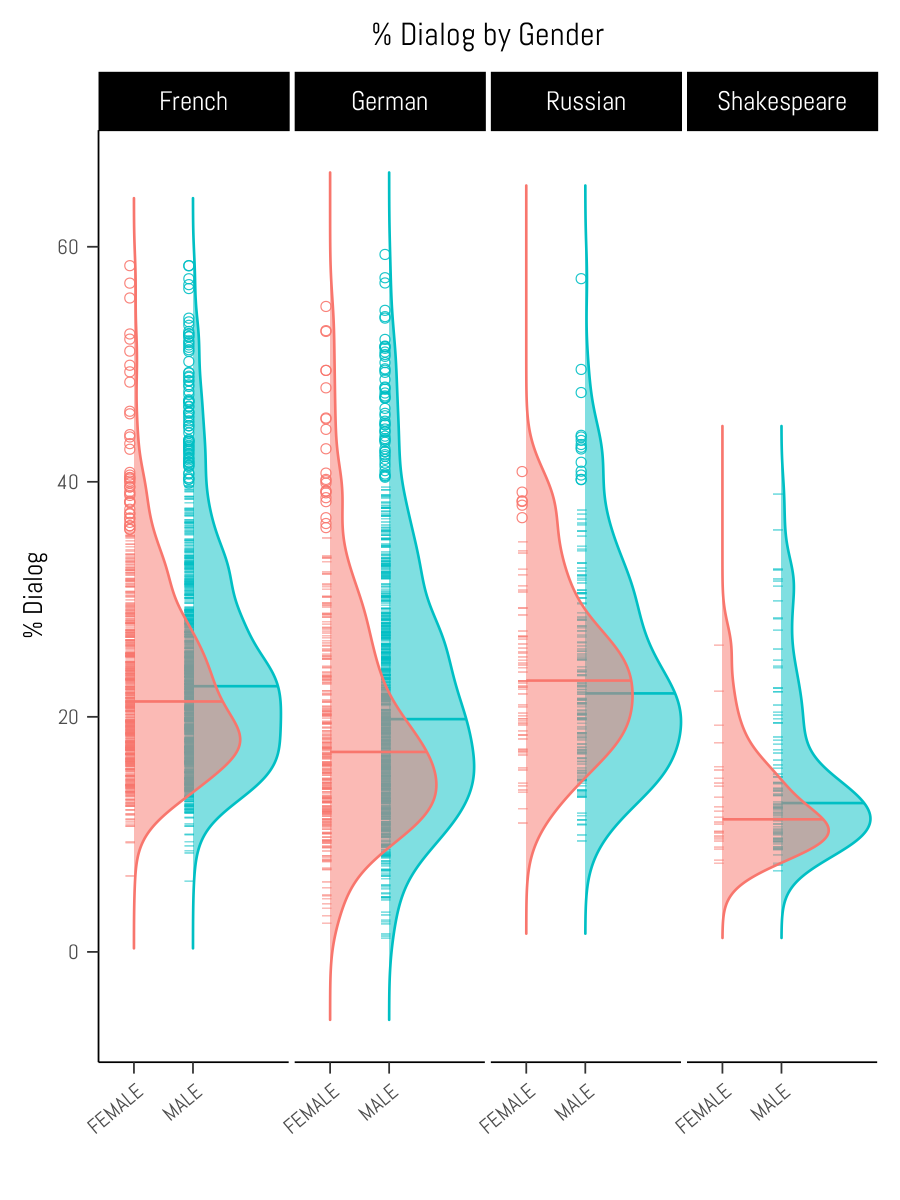

In [1448]:
%%R -i consolidated -h 4 -w 3 -u in -r 300

df <- consolidated %>% 
    filter(PctDialog < 60) %>%
    filter(gender != 'UNKNOWN')

library(ggridges)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

# 'standard' IQR scale for outliers is 1.5, but that is
# really meant for gaussian dists, which this definitely isn't.
# However this is, essentially, a magic number to make the
# outlier threshhold look 'right' (to me)
iqr_scale <- 1.5

# this is a very small df (4 rows)
boundaries <- df %>% 
    group_by(gender) %>% 
    summarize(
        # for each corpus, get the edges of the outlier band
        # which is IQR*iqr_scale above 3Q and below 1Q
        'Hi' = (IQR(PctDialog)*iqr_scale) + quantile(PctDialog)[3],
        'Lo' = quantile(PctDialog)[1] - (IQR(PctDialog)*iqr_scale)
    )
# don't know a better way to do this? merge those boundaries in
# to the whole main df so every row has a Hi and Lo entry, then filter
# for rows where the VocabSz is outside the bounds
outliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(PctDialog > Hi | PctDialog < Lo)
inliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(PctDialog < Hi & PctDialog > Lo)

ggplot(df, aes(PctDialog, gender, fill = gender, color=gender)) +
geom_point(data=inliers, shape='–', size=6, position = position_nudge(y = -0.06), alpha=0.5) +
geom_point(data=outliers, shape=1, size=1, stroke=0.2, position = position_nudge(y = -0.07),alpha=0.9) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.3
) +
coord_flip(clip="off") +
facet_wrap(~corpus, labeller=lbl, nrow = 1) +


theme_bw() +
xlab("% Dialog") +
ylab("") +
ggtitle("% Dialog by Gender") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=24),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=20, family="fnt"),
    strip.text.x=element_text(size=20, family="fnt",color='white'),
    strip.background=element_rect(color='black',fill='black'),
    panel.spacing = unit(0.1, "lines"),
    axis.text.x=element_text(angle = 40, hjust = 1),
)

R[write to console]: Picking joint bandwidth of 47.2

R[write to console]: Picking joint bandwidth of 78.3

R[write to console]: Picking joint bandwidth of 90.4

R[write to console]: Picking joint bandwidth of 99.9



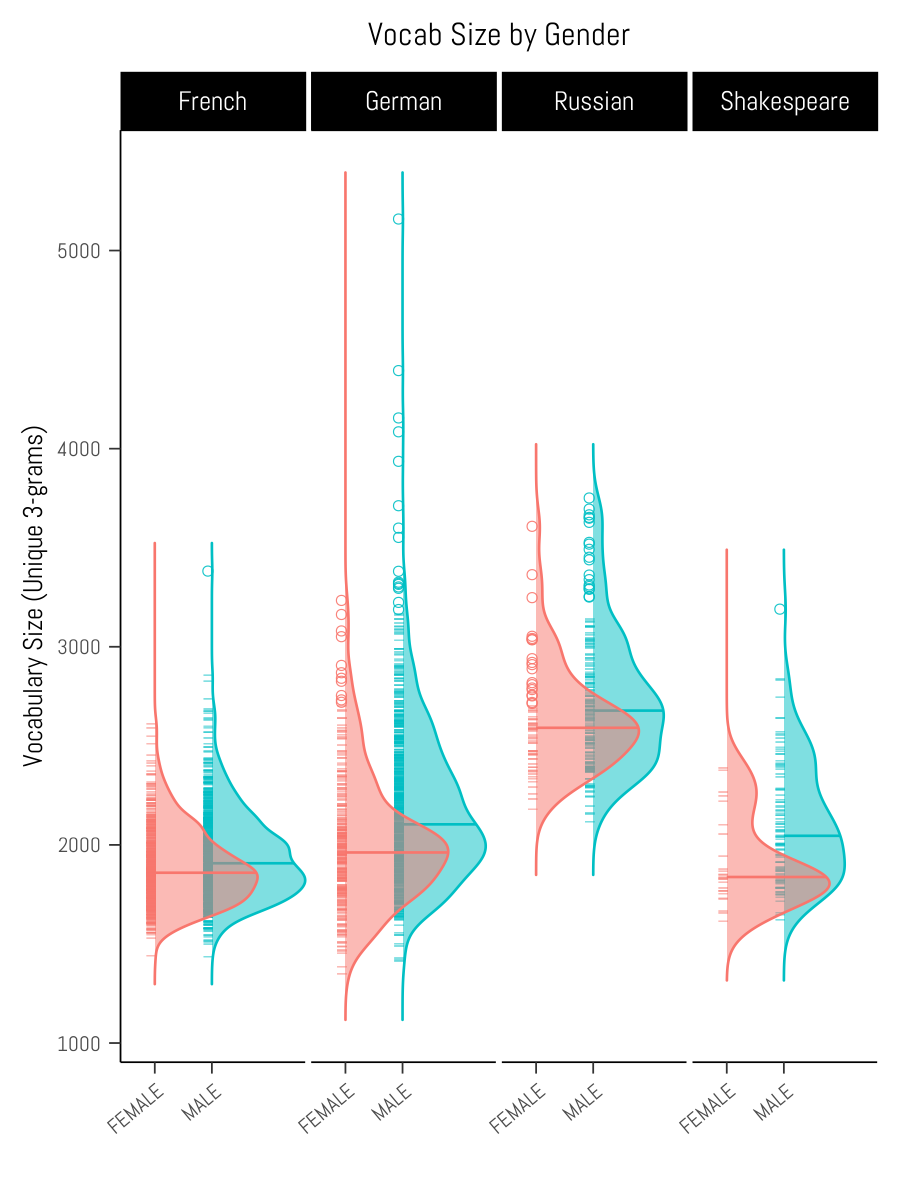

In [1451]:
%%R -i consolidated -h 4 -w 3 -u in -r 300

df <- consolidated %>% 
    filter(PctDialog < 60) %>%
    filter(gender != 'UNKNOWN')

library(ggridges)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

# 'standard' IQR scale for outliers is 1.5, but that is
# really meant for gaussian dists, which this definitely isn't.
# However this is, essentially, a magic number to make the
# outlier threshhold look 'right' (to me)
iqr_scale <- 2.5

# this is a very small df (4 rows)
boundaries <- df %>% 
    group_by(gender) %>% 
    summarize(
        # for each corpus, get the edges of the outlier band
        # which is IQR*iqr_scale above 3Q and below 1Q
        'Hi' = (IQR(VocabSz)*iqr_scale) + quantile(VocabSz)[3],
        'Lo' = quantile(VocabSz)[1] - (IQR(VocabSz)*iqr_scale)
    )
# don't know a better way to do this? merge those boundaries in
# to the whole main df so every row has a Hi and Lo entry, then filter
# for rows where the VocabSz is outside the bounds
outliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(VocabSz > Hi | VocabSz < Lo)
inliers <- tibble(merge(df, boundaries, by = 'gender')) %>%
    filter(VocabSz < Hi & VocabSz > Lo)

ggplot(df, aes(VocabSz, gender, fill = gender, color=gender)) +
geom_point(data=inliers, shape='–', size=6, position = position_nudge(y = -0.06), alpha=0.5) +
geom_point(data=outliers, shape=1, size=1, stroke=0.2, position = position_nudge(y = -0.07),alpha=0.9) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.3
) +
coord_flip(clip="off") +
facet_wrap(~corpus, labeller=lbl, nrow = 1) +


theme_bw() +
xlab("Vocabulary Size (Unique 3-grams)") +
ylab("") +
ggtitle("Vocab Size by Gender") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=24),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=20, family="fnt"),
    strip.text.x=element_text(size=20, family="fnt",color='white'),
    strip.background=element_rect(color='black',fill='black'),
    panel.spacing = unit(0.1, "lines"),
    axis.text.x=element_text(angle = 40, hjust = 1),
)

In [1501]:
# let's never speak of this again

a = consolidated.groupby(['corpus','gender']).agg('count')

# we need to do it this way so we have matching DF sizes
# while still using the count data we created above
b = a.groupby(['corpus']).transform('sum')

# Corpus Breakdown by Gender

In [1502]:
pd.DataFrame((a/b*100).round(2).id)

id
corpus gender        
fre    FEMALE   32.97
       MALE     55.91
       UNKNOWN  11.12
ger    FEMALE   25.63
       MALE     74.28
       UNKNOWN   0.08
rus    FEMALE   27.82
       MALE     72.18
shake  FEMALE   20.47
       MALE     79.53

# 10 Most Distinctive Characters by Corpus

## (Chars with more than 60% Dialog removed bc the stats go bonkers)

In [1456]:
consolidated.query('PctDialog < 60').groupby('corpus').apply(lambda grp: grp.nlargest(10, columns='VersusOther50'))[['Char', 'gender', 'Play', 'VersusOther50','yearNormalized']]

Char   gender  \
corpus                                         
fre    2613               Angélique   FEMALE   
       2717                 Béralde     MALE   
       2398                  Gilles     MALE   
       2722                Sbrigani     MALE   
       3085               Pierrette  UNKNOWN   
       2633              Le Marquis     MALE   
       3070                 Eugénie   FEMALE   
       2185                 Alcidon     MALE   
       2705               Henriette   FEMALE   
       2337                   Rose.   FEMALE   
ger    1090               Christine   FEMALE   
       1261                 Emerike   FEMALE   
       635                     Toni   FEMALE   
       1152                    Lore   FEMALE   
       749                    Gurli   FEMALE   
       594                 Arabella   FEMALE   
       305                     Anna   FEMALE   
       514                   Traute     MALE   
       279                  Woyzeck     MALE   
       522         Joseph Schindler     MALE   
rus    1451                 Аннушка   FEMALE   
       1430                  Лариса   FEMALE   
       1542                Вилицкий     MALE   
       1310      Инна Александровна   FEMALE   
       1416                   Пален     MALE   
       1446                Краснова   FEMALE   
       1464                    Юлия   FEMALE   
       1497  Незнакомый (Граф Юрий)     MALE   
       1443                  Параша   FEMALE   
       1503                 Княгиня   FEMALE   
shake  36          Captain Fluellen     MALE   
       115                 Pandarus     MALE   
       89                     Nurse   FEMALE   
       116                 Cressida   FEMALE   
       0                Nick Bottom     MALE   
       100         Mistress Quickly   FEMALE   
       93    Antipholus of Syracuse     MALE   
       94        Dromio of Syracuse     MALE   
       43                      Cade     MALE   
       63                      King     MALE   

                                                 Play  VersusOther50  \
corpus                                                                 
fre    2613                          marivaux-epreuve       0.211615   
       2717                 moliere-malade-imaginaire       0.199233   
       2398                 gueullette-fausses-envies       0.193318   
       2722             moliere-monsieur-pourceaugnac       0.184238   
       3085                              sand-moliere       0.176027   
       2633                             marivaux-legs       0.169826   
       3070             rougemont-discours-de-rentree       0.166653   
       2185                    desmarets-visionnaires       0.164325   
       2705                   moliere-femmes-savantes       0.163870   
       2337                           genlis-curieuse       0.159946   
ger    1090                       schnitzler-liebelei       0.237944   
       1261               weissenthurn-das-manuscript       0.233864   
       635            holz-schlaf-die-familie-selicke       0.221378   
       1152             sudermann-stein-unter-steinen       0.215729   
       749           kotzebue-die-indianer-in-england       0.212317   
       594                      hofmannsthal-arabella       0.204476   
       305                      devrient-hans-heiling       0.199173   
       514                      hartleben-rosenmontag       0.198148   
       279                           buechner-woyzeck       0.197552   
       522             hauptmann-carl-ephraims-breite       0.197331   
rus    1451                 ostrovsky-na-bojkom-meste       0.193531   
       1430                  ostrovsky-bespridannitsa       0.178503   
       1542                        turgenev-holostjak       0.173049   
       1310                        andreyev-k-zvezdam       0.170646   
       1416                 merezhkovsky-pavel-pervyj       0.166754   
       1446  ostrovsky-greh-da-beda-na-kogo-ne-zhivet       0.166433  

# Word Cloud Stuff!

In [776]:
women_words = Counter()
_ = allstars[(allstars.corpus=='shake') & (allstars.gender=='FEMALE')].cleanText.str.split(' ').apply(women_words.update)

In [778]:
men_words = Counter()
_ = allstars[(allstars.corpus=='shake') & (allstars.gender=='MALE')].cleanText.str.split(' ').apply(men_words.update)

In [777]:
len(women_words)

9819

In [779]:
len(men_words)

24182

In [943]:
men_words.most_common(20)

[('the', 21348),
 ('and', 19776),
 ('i', 16353),
 ('to', 15221),
 ('of', 13373),
 ('a', 11154),
 ('you', 11050),
 ('my', 9764),
 ('in', 8756),
 ('that', 8669),
 ('is', 7459),
 ('not', 6743),
 ('it', 6169),
 ('for', 6157),
 ('me', 6059),
 ('with', 5803),
 ('this', 5606),
 ('be', 5465),
 ('his', 5353),
 ('your', 5330)]

In [933]:
results = []
mw = men_words.most_common(500)
mw_sum = sum(men_words.values())
ww_sum = sum(women_words.values())
# Take the 500 most common male words, and, if it appears in
# the female list, store the relative frequency. If it's
# used more by men, 'rel' will be > 1. By doing the rel freq
# most of the function words etc should drop out because they'll
# have rel freqs closeish to 1.
for w, cnt in mw:
    if women_words[w]:
        mpct = cnt/mw_sum*100
        fpct = women_words[w]/ww_sum*100
        results.append({
            'word': w,
            'rel': mpct/fpct,
        })
words_df = pd.DataFrame(results)
# top 100 by relative freq (spoken more by men)
men = words_df.sort_values(by='rel',ascending=False).head(100)        
        

In [832]:
results = []
ww = women_words.most_common(500)
mw_sum = sum(men_words.values())
ww_sum = sum(women_words.values())
for w, cnt in ww:
    if men_words[w]:
        fpct = cnt/ww_sum*100
        mpct = men_words[w]/mw_sum*100
        results.append({
            'word': w,
            'rel': fpct/mpct,
        })
words_df = pd.DataFrame(results)
women = words_df.sort_values(by='rel',ascending=False).head(100)        
        

In [896]:
# scale the raw results a bit to make the wordcloud dramatic
women['tst'] = women.rel.apply(lambda x: (x**1.5//1)+3)
women

word       rel   tst
425  husbands  6.455384  19.0
118   husband  5.555543  16.0
257     romeo  5.372742  15.0
380     nurse  4.778661  13.0
167      alas  4.012438  11.0
..        ...       ...   ...
131       nay  1.357494   4.0
256    honest  1.354865   4.0
331      wish  1.351127   4.0
325      seek  1.350429   4.0
192     words  1.345333   4.0

[100 rows x 3 columns]

In [898]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [940]:
dfw = women.drop('rel',axis=1)
dw = dict(zip(dfw.word,dfw.tst))

In [938]:
men['tst'] = men.rel.apply(lambda x: (x**1.6//1)+3)
dfm = men.drop('rel',axis=1)
dm = dict(zip(dfm.word,dfm.tst))

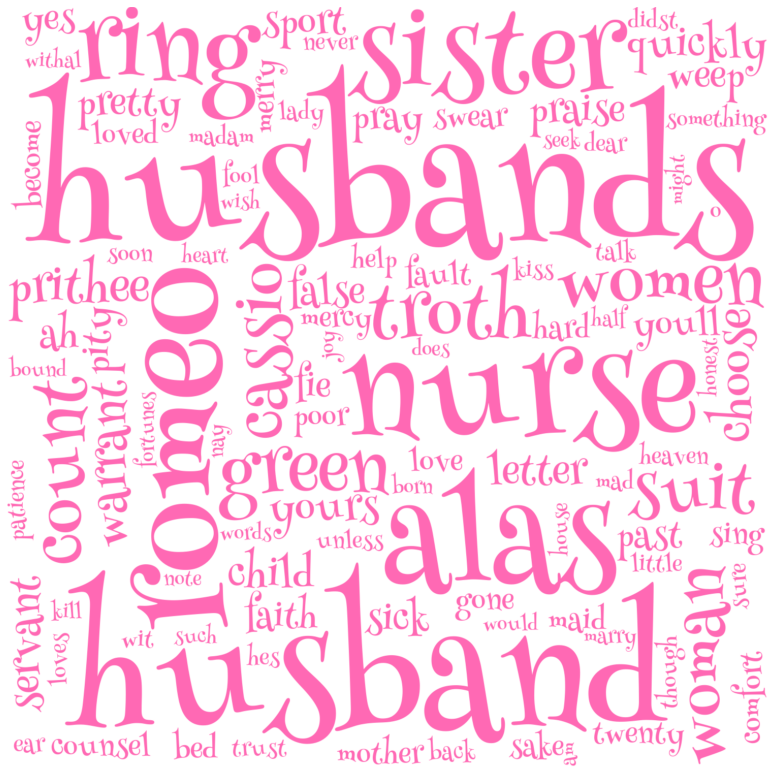

In [942]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hotpink")

wordcloud = WordCloud(font_path='../../HennyPenny-Regular.ttf',background_color="white", width=1500, height=1500).generate_from_frequencies(dw)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[14,14])
plt.axis("off")
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")



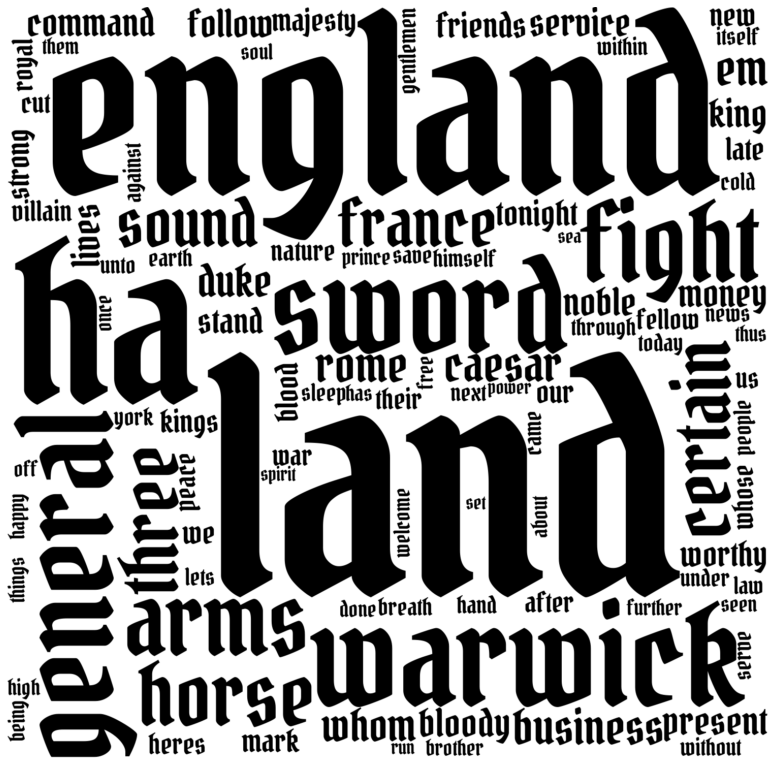

In [939]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("black")

wordcloud = WordCloud(font_path='../../Bokor-Regular.ttf',background_color="white", width=1500, height=1500).generate_from_frequencies(dm)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[14,14])
plt.axis("off")
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")


In [960]:
Counter([x[0] for x in allstars_long.playName.str.split('-')]).most_common(20)

[('corneillep', 125),
 ('corneillet', 112),
 ('voltaire', 72),
 ('marivaux', 65),
 ('ostrovsky', 63),
 ('rotrou', 54),
 ('la', 50),
 ('moliere', 50),
 ('du', 45),
 ('racine', 44),
 ('boyer', 41),
 ('schiller', 41),
 ('goethe', 40),
 ('kotzebue', 35),
 ('dancourt', 34),
 ('hebbel', 34),
 ('schnitzler', 31),
 ('lessing', 31),
 ('hofmannsthal', 30),
 ('grillparzer', 29)]

# OLD STUFF

Based on the previous dataframes, only kept around in case we need to cut & paste the ggplot code

In [965]:
energy_df_fre

id           Char                 Play  VocabSz   PctVocab  \
0      3707        Argélie      abeille-argelie     2074  77.561705   
1      3710        Phoenix      abeille-argelie     1821  68.100224   
2      3711         Ismene      abeille-argelie     2087  78.047868   
3      3715     C. Martius     abeille-coriolan     2200  82.956259   
4      3718        Virgile     abeille-coriolan     1718  64.781297   
...     ...            ...                  ...      ...        ...   
1739  19229      Madeleine       zola-madeleine     1674  71.112999   
1740  19235        Laurent  zola-therese-raquin     1955  63.268608   
1741  19236        Therese  zola-therese-raquin     2052  66.407767   
1742  19237  Madame Raquin  zola-therese-raquin     1735  56.148867   
1743  19240        Suzanne  zola-therese-raquin     1730  55.987055   

      PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
0     25.511819     0.019432      0.025441      0.029758      0.034898   
1     19.849961     0.019746      0.025320      0.029151      0.033466   
2     30.694993     0.019561      0.025342      0.029674      0.034259   
3     36.380319     0.019637      0.025785      0.029700      0.034715   
4     18.811606     0.019491      0.025407      0.029120      0.033819   
...         ...          ...           ...           ...           ...   
1739  38.274443     0.021877      0.028332      0.032530      0.037431   
1740  17.936107     0.016565      0.022139      0.025193      0.028801   
1741  21.084844     0.017173      0.022328      0.025785      0.029682   
1742  14.797206     0.016704      0.021379      0.024850      0.028975   
1743  15.027815     0.016828      0.021613      0.024993      0.028655   

      VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
0         0.045001      0.029189       0.040118       0.045887       0.052447   
1         0.042376      0.082701       0.097437       0.105794       0.114523   
2         0.045893      0.036968       0.048697       0.055328       0.063262   
3         0.046794      0.023257       0.031067       0.036722       0.042009   
4         0.044335      0.090636       0.104661       0.113301       0.121832   
...            ...           ...            ...            ...            ...   
1739      0.048518      0.095153       0.113839       0.122928       0.131861   
1740      0.037277      0.050635       0.064803       0.071836       0.079548   
1741      0.038792      0.042909       0.056136       0.063189       0.070247   
1742      0.037680      0.110823       0.125611       0.132719       0.141234   
1743      0.038028      0.103051       0.116507       0.124474       0.131573   

      VersusOther95   gender  
0          0.064864   FEMALE  
1          0.129362     MALE  
2          0.079746   FEMALE  
3          0.053667     MALE  
4          0.135552  UNKNOWN  
...             ...      ...  
1739       0.150471   FEMALE  
1740       0.093777     MALE  
1741       0.086257  UNKNOWN  
1742       0.154184   FEMALE  
1743       0.146811   FEMALE  

[1744 rows x 17 columns]

In [967]:
corneille = energy_df_fre[energy_df_fre.Play.apply(lambda x: x.split('-')[0])=='corneillep']
corneille

id        Char                 Play  VocabSz   PctVocab  PctDialog  \
272  6583    Aglatide  corneillep-agesilas     1672  60.426455  14.304761   
273  6585  Spitridate  corneillep-agesilas     1818  65.702927  17.274671   
274  6587     Mandane  corneillep-agesilas     1810  65.413806  16.414960   
275  6588    Lysander  corneillep-agesilas     1676  60.571016  12.796819   
276  6590    Agésilas  corneillep-agesilas     1983  71.666064  21.755971   
..    ...         ...                  ...      ...        ...        ...   
392  6954    Philiste     corneillep-veuve     2114  72.972040  24.378542   
393  6960     Célidan     corneillep-veuve     1707  58.923024  14.040028   
394  6965    Philiste  corneillep-veuve-34     2120  72.802198  24.379310   
395  6966     Alcidon  corneillep-veuve-34     1959  67.273352  19.363471   
396  6972     Célidan  corneillep-veuve-34     1696  58.241758  13.547111   

     VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  VersusSelf95  \
272     0.018876      0.023994      0.027324      0.031573      0.042492   
273     0.019055      0.024351      0.027779      0.031992      0.041979   
274     0.018779      0.024724      0.028143      0.032122      0.041710   
275     0.018779      0.024114      0.027854      0.032073      0.041742   
276     0.018793      0.024787      0.028521      0.033099      0.042804   
..           ...           ...           ...           ...           ...   
392     0.018447      0.024054      0.027966      0.032322      0.042333   
393     0.017628      0.023310      0.026622      0.031273      0.041640   
394     0.017389      0.023412      0.026750      0.031082      0.040996   
395     0.017831      0.023452      0.026935      0.031006      0.040400   
396     0.017618      0.023240      0.026627      0.030998      0.039871   

     VersusOther5  VersusOther25  VersusOther50  VersusOther75  VersusOther95  \
272      0.104936       0.120963       0.129978       0.138133       0.152315   
273      0.070391       0.085144       0.093144       0.100428       0.116820   
274      0.064900       0.078026       0.085085       0.092584       0.108649   
275      0.080973       0.094999       0.101769       0.109919       0.124792   
276      0.033312       0.046010       0.053130       0.059639       0.072666   
..            ...            ...            ...            ...            ...   
392      0.031981       0.044324       0.050732       0.058307       0.072699   
393      0.101016       0.113932       0.122125       0.129348       0.145440   
394      0.032163       0.043655       0.050657       0.057619       0.071280   
395      0.056277       0.070658       0.078345       0.086506       0.100751   
396      0.105273       0.119614       0.127192       0.134678       0.150636   

     gender  
272  FEMALE  
273    MALE  
274  FEMALE  
275    MALE  
276    MALE  
..      ...  
392    MALE  
393    MALE  
394    MALE  
395    MALE  
396    MALE  

[125 rows x 17 columns]

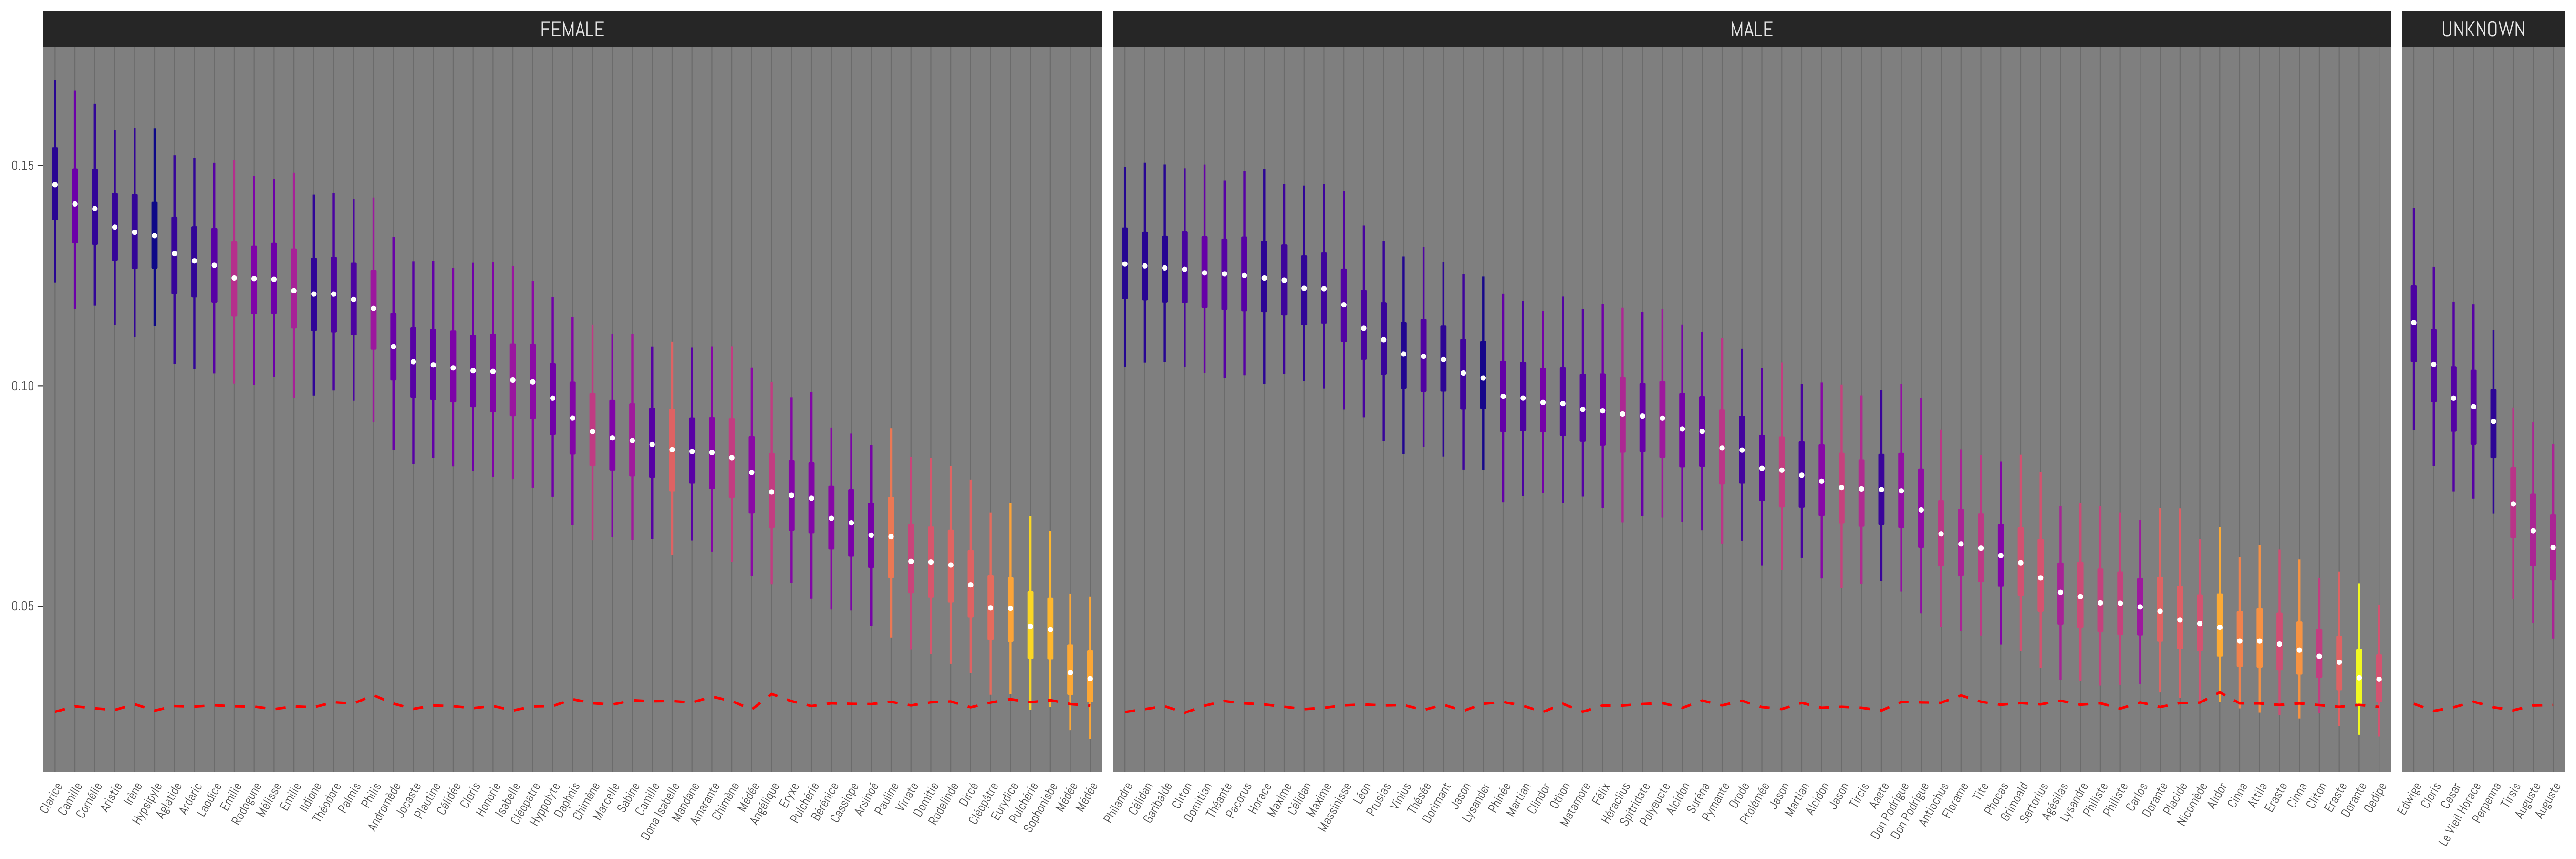

In [1025]:
%%R -i corneille -h 6 -w 18 -u in -r 300

library(ggplot2)
library(viridis)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- corneille
rem_ids <- function(lab) sub('\\..*','', lab)

ggplot(df, aes(x=reorder(interaction(Char,id),-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,id)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +

scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
# the labels right now are interaction terms with 
# the id like Fred.46546, so remove the trailing
# dot and id with as regexp
scale_x_discrete(labels=rem_ids) +
theme_dark() +
facet_grid(~gender,scales='free_x',space='free_x') +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=25, family="fnt"),
    strip.text.x=element_text(size=33, family="fnt"),

)

In [970]:
len(corneille[corneille.gender=='FEMALE'])

53

In [990]:
moliere = energy_df_fre[energy_df_fre.Play.apply(lambda x: x.split('-')[0])=='moliere']
moliere.head()

id        Char                        Play  VocabSz   PctVocab  \
1126  13371    Clitidas  moliere-amants-magnifiques     1685  62.407407   
1127  13423     Mercure          moliere-amphitryon     1772  61.314879   
1128  13425       Sosie          moliere-amphitryon     2104  72.802768   
1129  13429  Amphitryon          moliere-amphitryon     1751  60.588235   
1130  13434      Valère               moliere-avare     1781  57.862248   

      PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
1126  19.657706     0.019016      0.024735      0.028400      0.032869   
1127  16.915151     0.018388      0.023253      0.026936      0.030972   
1128  28.694808     0.017765      0.023304      0.027166      0.032171   
1129  16.432759     0.018375      0.023407      0.026883      0.031165   
1130  13.297962     0.016994      0.021746      0.024887      0.029015   

      VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
1126      0.042378      0.080264       0.095190       0.102563       0.111141   
1127      0.040642      0.092467       0.105896       0.113155       0.120699   
1128      0.042463      0.040883       0.054535       0.063762       0.072029   
1129      0.041251      0.087208       0.103675       0.110350       0.117680   
1130      0.038309      0.075056       0.089751       0.097299       0.104757   

      VersusOther95 gender  
1126       0.126281   MALE  
1127       0.135326   MALE  
1128       0.086845   MALE  
1129       0.132739   MALE  
1130       0.119049   MALE

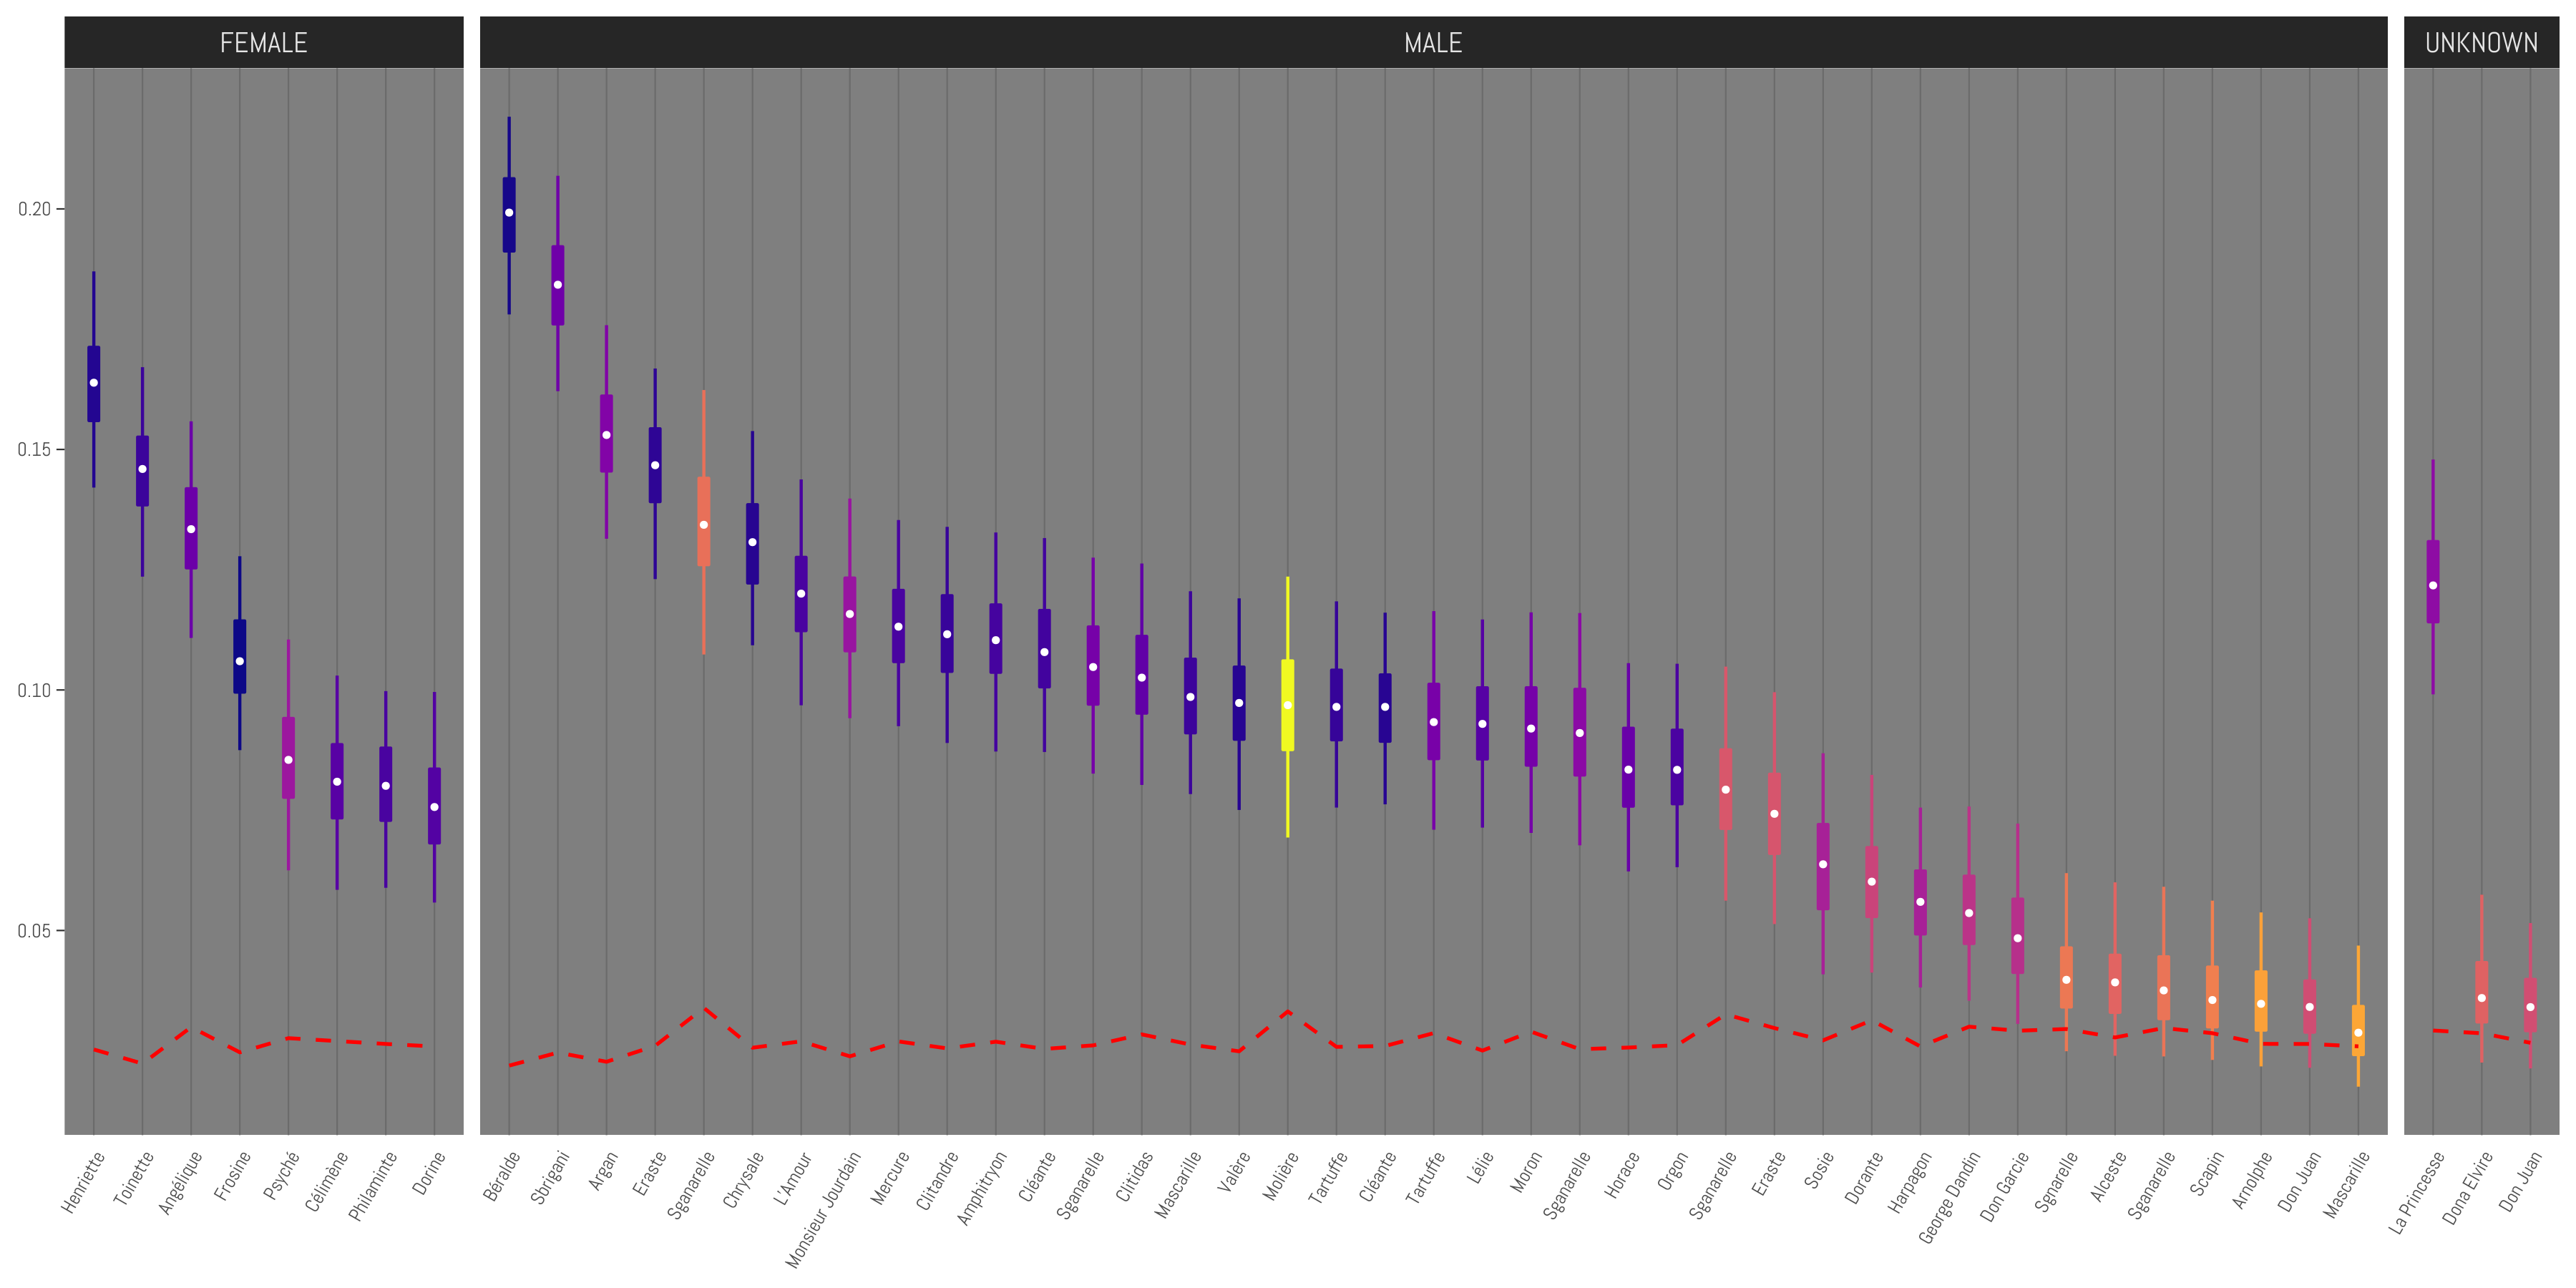

In [1029]:
%%R -i moliere -h 6 -w 12 -u in -r 300

library(ggplot2)
library(viridis)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- moliere
rem_ids <- function(lab) sub('\\..*','', lab)

ggplot(df, aes(x=reorder(interaction(Char,id),-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,id)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +

scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
# the labels right now are interaction terms with 
# the id like Fred.46546, so remove the trailing
# dot and id with as regexp
scale_x_discrete(labels=rem_ids) +
theme_dark() +
facet_grid(~gender,scales='free_x',space='free_x') +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=25, family="fnt"),
    strip.text.x=element_text(size=30, family="fnt"),

)

In [991]:
moliere[moliere.Char.str.startswith('Moli')]

id     Char                          Play  VocabSz   PctVocab  \
1157  13659  Molière  moliere-impromptu-versailles     2075  88.523891   

      PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
1157    58.3733     0.022086      0.029085      0.033178      0.038998   

      VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
1157      0.049942      0.069323       0.087602       0.096838       0.106043   

      VersusOther95 gender  
1157        0.12357   MALE

In [994]:
allstars[allstars.playName.str.startswith('moliere-imprompt')]

id                   label  isGroup   gender corpus  \
13659  13659                 Molière    False     MALE    fre   
13660  13660                Brécourt    False     MALE    fre   
13661  13661               La Grange    False  UNKNOWN    fre   
13662  13662               Du Croisy    False     MALE    fre   
13663  13663    Mademoiselle du Parc    False   FEMALE    fre   
13664  13664     Mademoiselle Béjart    False   FEMALE    fre   
13665  13665    Mademoiselle de Brie    False   FEMALE    fre   
13666  13666  Mademoiselle du Croisy    False   FEMALE    fre   
13667  13667      Mademoiselle Hervé    False   FEMALE    fre   
13668  13668    Mademoiselle Molière    False   FEMALE    fre   
13669  13669          La Thorillière    False     MALE    fre   
13670  13670                  Béjart    False     MALE    fre   
13671  13671           Un Necessaire    False  UNKNOWN    fre   
13672  13672        Autre Necessaire    False  UNKNOWN    fre   

                           playName  \
13659  moliere-impromptu-versailles   
13660  moliere-impromptu-versailles   
13661  moliere-impromptu-versailles   
13662  moliere-impromptu-versailles   
13663  moliere-impromptu-versailles   
13664  moliere-impromptu-versailles   
13665  moliere-impromptu-versailles   
13666  moliere-impromptu-versailles   
13667  moliere-impromptu-versailles   
13668  moliere-impromptu-versailles   
13669  moliere-impromptu-versailles   
13670  moliere-impromptu-versailles   
13671  moliere-impromptu-versailles   
13672  moliere-impromptu-versailles   

                                               cleanText  
13659  allons donc messieurs et mesdames vous moquezv...  
13660  quoi que voulezvous quon fasse nous ne savons ...  
13661  questce le moyen de jouer ce quon ne sait pas ...  
13662  plaîtil jen voudrais être quitte pour dix pist...  
13663  hé bien quelle est votre pensée pour moi je vo...  
13664  quy atil eh bien nous voilà que prétendezvous ...  
13665  que veuton de quoi estil question je sais bien...  
13666  questce que cest ni moi non plus mais avec cel...  
13667  on y va pour moi je nai pas grandchose à dire ...  
13668  et moi aussi voulezvous que je vous dise vous ...  
13669  bonjour monsieur molière comment vous en va je...  
13670  messieurs je viens vous avertir que le roi est...  
13671                           messieurs commencez donc  
13672  messieurs commencez donc messieurs commencez d...

In [993]:
allstars.head()

id       label  isGroup gender corpus                          playName  \
0   0    Мирволин    False   MALE    rus  turgenev-zavtrak-u-predvoditelja   
1   1     Герасим    False   MALE    rus  turgenev-zavtrak-u-predvoditelja   
2   2  Балагалаев    False   MALE    rus  turgenev-zavtrak-u-predvoditelja   
3   3  Вельвицкий    False   MALE    rus  turgenev-zavtrak-u-predvoditelja   
4   4     Алупкин    False   MALE    rus  turgenev-zavtrak-u-predvoditelja   

                                           cleanText  
0  здравствуй герасим как поживаешь а что он еще ...  
1  здравствуйте где это вы достали лошадь кто пре...  
2  филька вельвицкого мне позвать так так тактакт...  
3  как жес как жес слушаюс так стало бытьс бумаги...  
4  доложи аалупкин дворянин покорнейше благодарю ...

In [1012]:
ostrov = energy_df_rus[energy_df_rus.Play.apply(lambda x: x.split('-')[0])=='ostrovsky']
ostrov.head()

id               Char                       Play  VocabSz   PctVocab  \
113  1876      Анна Петровна  ostrovsky-bednaja-nevesta     2691  63.452016   
114  1877    Марья Андреевна  ostrovsky-bednaja-nevesta     2606  61.447772   
115  2764            Телятев   ostrovsky-beshenye-dengi     3254  65.001998   
116  2765          Васильков   ostrovsky-beshenye-dengi     2920  58.330004   
117  2767  Надежда Антоновна   ostrovsky-beshenye-dengi     2587  51.677986   

     PctDialog  VersusSelf5  VersusSelf25  VersusSelf50  VersusSelf75  \
113  20.134267     0.012530      0.016786      0.019552      0.023256   
114  24.838365     0.012486      0.016465      0.019301      0.022793   
115  22.669466     0.010978      0.014449      0.016879      0.019980   
116  19.178164     0.010956      0.014614      0.017030      0.020285   
117  14.385123     0.010883      0.014182      0.016804      0.019678   

     VersusSelf95  VersusOther5  VersusOther25  VersusOther50  VersusOther75  \
113      0.031200      0.062864       0.075924       0.082127       0.088747   
114      0.030920      0.107252       0.120618       0.126993       0.133502   
115      0.028154      0.032509       0.042257       0.047577       0.052972   
116      0.027091      0.073498       0.084759       0.091043       0.097215   
117      0.025981      0.112208       0.122414       0.128760       0.134726   

     VersusOther95  gender  
113       0.101139  FEMALE  
114       0.146355  FEMALE  
115       0.064569    MALE  
116       0.109163    MALE  
117       0.146763  FEMALE

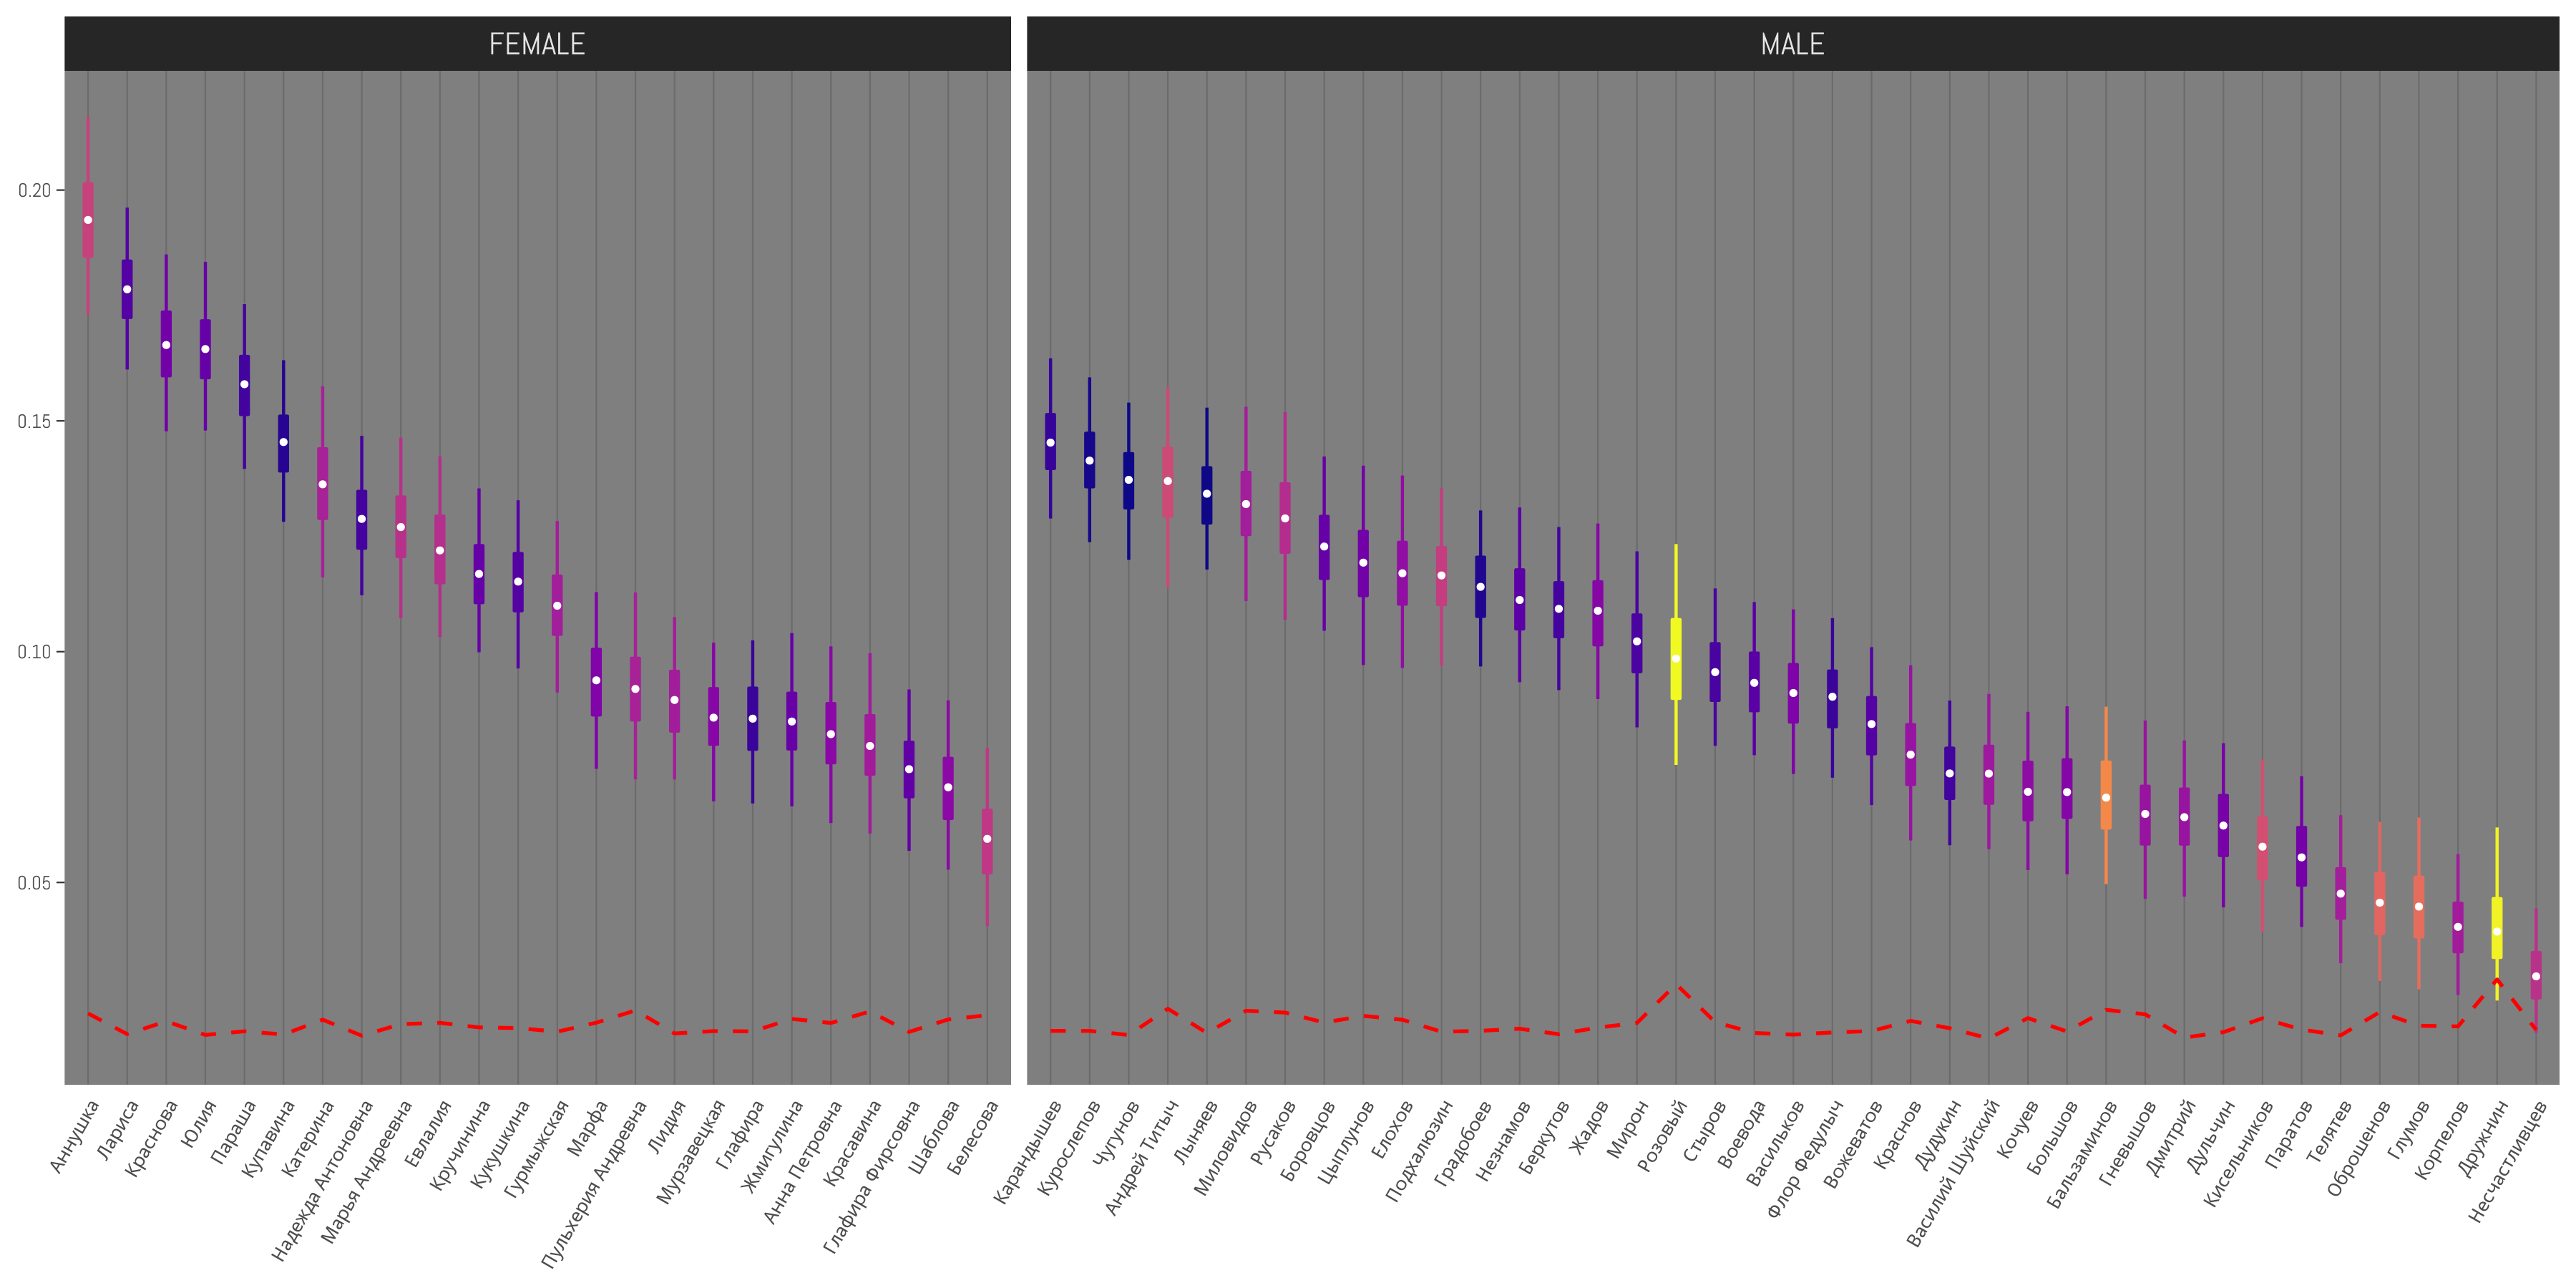

In [1034]:
%%R -i ostrov -h 6 -w 12 -u in -r 300

library(ggplot2)
library(viridis)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

df <- ostrov
rem_ids <- function(lab) sub('\\..*','', lab)

ggplot(df, aes(x=reorder(interaction(Char,id),-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,id)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +

scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
# the labels right now are interaction terms with 
# the id like Fred.46546, so remove the trailing
# dot and id with as regexp
scale_x_discrete(labels=rem_ids) +
theme_dark() +
facet_grid(~gender,scales='free_x',space='free_x') +

theme(
    panel.border = element_blank(),
    legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1, family="Envy Code R"),
    text=element_text(size=25, family="fnt"),
    strip.text.x=element_text(size=33, family="fnt"),

)

# Slightly Tidier Wordcloud Stuff

In [1042]:
def rel_freqs(source, other, source_n=500):
    
    source_cnt = Counter()
    _ = source.cleanText.str.split(' ').apply(source_cnt.update)
    other_cnt = Counter()
    _ = other.cleanText.str.split(' ').apply(other_cnt.update)
    
    results = []
    sw = source_cnt.most_common(source_n)
    sw_sum = sum(source_cnt.values())
    ow_sum = sum(other_cnt.values())
    for sw, cnt in sw:
        s_prob = cnt/sw_sum
        o_prob = (other_cnt[sw]+1)/ow_sum # no div0 plz
        results.append({
            'word': sw,
            'rel': s_prob/o_prob,
        })
    return pd.DataFrame(results).sort_values(by='rel',ascending=False)
    

In [1055]:
def wc(probs, font_path=None, bg="white",width=500,height=500,cf=None):
    wordcloud = WordCloud(font_path=font_path,background_color=bg, width=width, height=height).generate_from_frequencies(probs)
    if cf:
        wordcloud.recolor(color_func = cf)
    return wordcloud.to_image()

In [1040]:
a = allstars[(allstars.corpus=='shake') & (allstars.gender=='FEMALE')]
b = allstars[(allstars.corpus=='shake') & (allstars.gender=='MALE')]

In [1046]:
rf = rel_freqs(a,b).head(100)
d = dict(zip(rf.word,rf.rel))

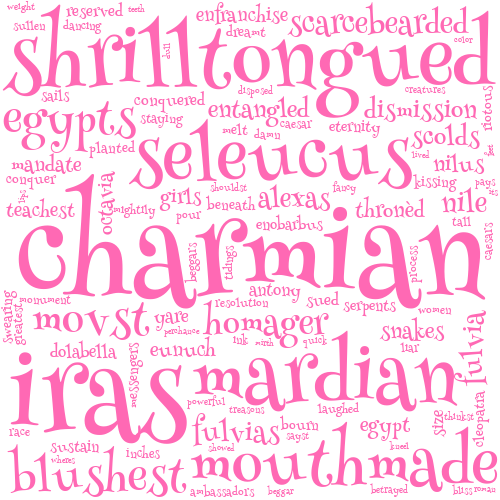

In [1066]:
def hotpink_f(*args, **kwargs):
    return("hotpink")

rf = rel_freqs(a,b).head(100)
d = dict(zip(rf.word,rf.rel))
wc(d, cf=hotpink_f, font_path='../../HennyPenny-Regular.ttf')

In [1065]:
a = allstars_long[allstars_long.label.str.startswith('Cleop')]
b = allstars[(allstars.corpus=='shake')]

In [1062]:
allstars_long

id           label  isGroup  gender corpus  \
2          2      Балагалаев    False    MALE    rus   
21        21  Дарья Ивановна    False  FEMALE    rus   
27        27      Граф Любин    False    MALE    rus   
28        28   Донья Долорес    False  FEMALE    rus   
29        29     Дон Рафаэль    False    MALE    rus   
...      ...             ...      ...     ...    ...   
34399  34399          Cloten    False    MALE  shake   
34402  34402         Iachimo    False    MALE  shake   
34410  34410        Belarius    False    MALE  shake   
34432  34432           Gower    False    MALE  shake   
34434  34434        Pericles    False    MALE  shake   

                               playName  \
2      turgenev-zavtrak-u-predvoditelja   
21               turgenev-provintsialka   
27               turgenev-provintsialka   
28              turgenev-neostorozhnost   
29              turgenev-neostorozhnost   
...                                 ...   
34399                         cymbeline   
34402                         cymbeline   
34410                         cymbeline   
34432                          pericles   
34434                          pericles   

                                               cleanText  
2      филька вельвицкого мне позвать так так тактакт...  
21     миша вы ходили к попову что он вам сказал жду ...  
27     что же это значит никого нет что ли зачем этот...  
28     однако мне очень скучно мне нечего читать я не...  
29     что бы вы сделали прекрасная сеньйора сеньйора...  
...                                                  ...  
34399  if my shirt were bloody then to shift it have ...  
34402  believe it sir i have seen him in britain he w...  
34410  a goodly day not to keep house with such whose...  
34432  to sing a song that old was sung from ashes an...  
34434  i have antiochus and with a soul emboldened wi...  

[3291 rows x 7 columns]

In [1155]:
a = allstars_long[(allstars_long.label.str.contains('Romeo')) & (allstars_long.corpus=='shake')]
b = allstars_long[(allstars_long.label.str.contains('Juliet')) & (allstars_long.corpus=='shake')]
#a = allstars_long[(allstars_long.gender=='FEMALE') & (allstars_long.corpus=='shake')]
#b = allstars[(allstars.corpus=='shake')]
#b = allstars_long[(allstars_long.gender=='MALE') & (allstars_long.corpus=='shake')]


In [ ]:
'../../Bokor-Regular.ttf'

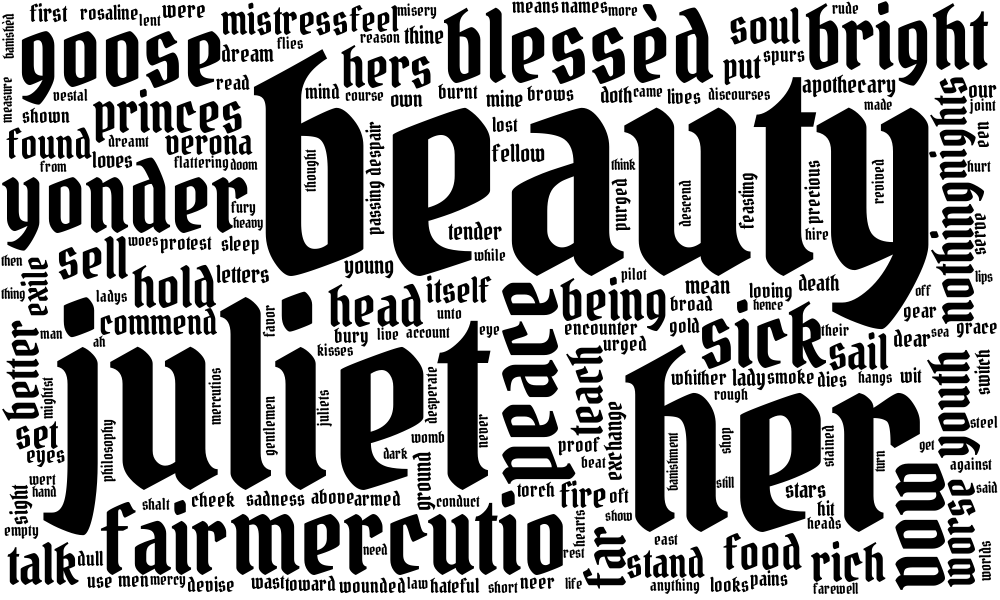

In [1158]:
def black_f(*args, **kwargs):
    return("black")

def pink_f(*args, **kwargs):
    return("hotpink")

rf = rel_freqs(a,b, source_n=500).head(200)
d = dict(zip(rf.word,rf.rel))
wc(d, cf=black_f, font_path='./PirataOne-Regular.ttf', width=1000, height=600)

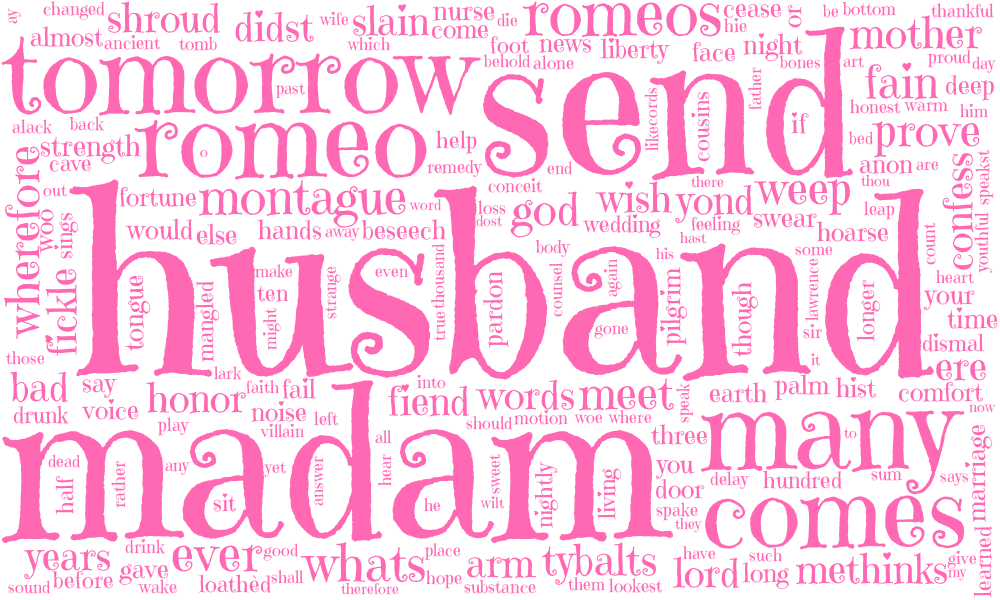

In [1160]:
def black_f(*args, **kwargs):
    return("black")

def pink_f(*args, **kwargs):
    return("hotpink")

rf = rel_freqs(b,a, source_n=500).head(200)
d = dict(zip(rf.word,rf.rel))
wc(d, cf=pink_f, font_path='./EmilysCandy-Regular.ttf', width=1000, height=600)